# Autores: Matheus do Ó e Vinícius Lima

# Predições de posições de jogadores do FIFA 23 via modelos de aprendizado de máquina supervisionado

Esse trabalho consiste em utilizar dois modelos para tentar prever posições de jogadores do jogo eletrônico FIFA 23. O dataset utilizado se encontra em https://www.kaggle.com/datasets/sanjeetsinghnaik/fifa-23-players-dataset.

O primeiro modelo utilizado foi uma rede neural MLP pura. Primeiro testamos algumas arquiteturas com diferentes funções de ativação para, enfim, determinar qual utilizar. Adicional a isso, tentamos avaliar a qualidade do modelo vendo suas acurácias, tanto em treino quanto em teste, e sua matriz de confusão. Outras análises eram desejadas, porém acabamos por não implementar.

O segundo modelo utilizado foi um ensemble. Basicamente dividimos as posições dos jogadores em duas regiões do campo: "ataque" e "defesa", para que então uma rede neural MLP classificasse os jogadores em uma dessas duas regiões, em seguida o jogador, baseado em que região foi classificado, era redirecionado para uma floresta aleatória especializada em posições dessa região. Uma breve discussão dos resultados desse modelo são feitas.

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as sklp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [2]:
#funções de treino, teste e construção de redes neurais

#constrói a rede neural
def constructNeuralNetwork(ls, input, output, activation="relu", optimizer="sgd",
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                           metrics=['accuracy']):
    '''
    Constrói um modelo de rede neural MLP baseado nos atributos passados
    Entrada:
        Quantidade de neurônios em cada camada escondida;
        Número de neurônios na camada de entrada;
        Número de neurônios na camada de saída;
        Função de ativação;
        Otimizador a ser utilizado;
        Função de perda a ser utilizada;
        Métrica a ser utilizada
    Saída:
        Um modelo baseado nos parâmetros passados
    '''

    #inicializa modelo e cria camada de entrada
    neuralNetwork = models.Sequential()
    neuralNetwork.add(layers.Dense(input, input_shape=(input,)))

    #cria camadas escondidas e camada de saída
    for l in ls:
        neuralNetwork.add(layers.Dense(l, activation=activation))
    neuralNetwork.add(layers.Dense(output))

    #compila o modelo com os parâmetros passados
    neuralNetwork.compile(optimizer="sgd",
                loss=loss,
                metrics=['accuracy'])
    return neuralNetwork


#treina para um conjunto em específico
def trainModel(X_train, y_train, X_val, y_val, neuralNetwork, epochs=10, verbose=0):
    '''
    Recebe um conjunto de dados e e um modelo e o treina. O retorno é este
    modelo treinado
    Entrada:
        Conjunto de treino e seus labels;
        Conjunto de teste e seus labels;
        Modelo de rede neural MLP;
        Quantidade de épocas;
        verbose: 0 para não pedir mensagens de impressão, 1 caso contrário.
    Saída:
        Modelo treinado;
        histórico do modelo.
    '''
    history = neuralNetwork.fit(X_train, y_train, epochs=epochs,
                        validation_data=(X_val, y_val), verbose=verbose)
    return neuralNetwork, history


def multipleTrains(X_train, y_train, kfold, ls, input=6, output=15, epochs=10, optimizer="sgd",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)):
    '''
    Treina modelos com uma dada arquitetura com 3 funções de ativação:
        1. Sigmoid
        2. Tangente hiperbólica
        3. ReLU
    Para isso utiliza um kfold previamente calculado e o aplica no conjunto
    de treino.
    Entrada:
        conjunto de treino e seus labels;
        Um objeto de Kfold, que particionará o conjunto de treino;
        Quantidade de neurônios em cada camada escondida;
        Número de neurônios na camada de entrada;
        Número de neurônios na camada de saída;
        Número de épocas
    Saída:
        Lista de histórico para o treino com a Sigmoid;
        Lista de histórico para o treino com a Tangente hiperbólica;
        Lista de histórico para o treino com a ReLU;
    Esses históricos contém informações como precisão no treino e teste.
    '''

    #inicializa lista de históricos
    sigHistory = []
    tanhHistory = []
    reluHistory = []

    k = 1
    #X_train_ = np.copy(X_train)
    #percorre as partições feitas pelo Kfold
    for trainIndex, testIndex in kfold.split(X_train):
        print(f"fold {k} começou")

        X_train_, X_test_, _ = standardData(X_train[trainIndex], X_train[testIndex])

        #constrói os modelos para cada função de ativação a ser usada
        sig = constructNeuralNetwork(ls, input, output, activation="sigmoid", optimizer=optimizer, loss=loss)
        tanh = constructNeuralNetwork(ls, input, output, activation="tanh", optimizer=optimizer, loss=loss)
        relu = constructNeuralNetwork(ls, input, output, activation="relu", optimizer=optimizer, loss=loss)

        #atualiza as listas de históricos de cada modelo

        _, hist = trainModel(X_train_, y_train[trainIndex],
                         X_test_, y_train[testIndex],
                         sig, epochs=epochs)

        sigHistory.append(hist)

        _, hist = trainModel(X_train_, y_train[trainIndex],
                         X_test_, y_train[testIndex],
                         tanh, epochs=epochs)

        tanhHistory.append(hist)

        _, hist = trainModel(X_train_, y_train[trainIndex],
                         X_test_, y_train[testIndex],
                         relu, epochs=epochs)

        reluHistory.append(hist)

        k+=1

    return sigHistory, tanhHistory, reluHistory

def testModel(X_train, y_train, X_test, y_test, verbose, ls, input, output, activation="relu", optimizer="sgd",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'], epochs=50):
    '''
    Treina e testa uma rede neural em três etapas:
        1. cria uma rede neural MLP baseada nos parâmetros passados;
        2. treina a rede neural com o conjunto de treinos passado;
        3. testa a rede neural com o conjunto de teste passado.
    Entrada:
        Conjuntos de treino e testes a serem utilizados;
        verbose: se 0, não mostra mensagens. Se 1, mostra.
        Quantidade de neurônios em cada camada escondida;
        Número de neurônios na camada de entrada;
        Número de neurônios na camada de saída;
        Função de ativação;
        Otimizador a ser utilizado;
        Função de perda a ser utilizada;
        Métrica a ser utilizada;
        Número de épocas para o treino.
    Saída:
        rede neural treinada;
        histórico do treino;
        valor da função de perda para o conjunto de testes;
        acurácia no conjunto de testes
    '''

    #constrói a rede neural
    neuralNetwork = constructNeuralNetwork(ls, input, output, activation, optimizer,
                                           loss, metrics)

    #testa o modelo
    neuralNetwork, history = trainModel(X_train, y_train, X_test, y_test, neuralNetwork, epochs, verbose)

    # avalia o modelo uma última vez, obtendo a função de perda no conjunto de teste
    # e a acurácia final.
    testLoss, testAccuracy = neuralNetwork.evaluate(X_test, y_test, verbose=2)

    return neuralNetwork, history, testLoss, testAccuracy


#printa os resultados de acurácia
def showResults(accuraciesMean, val_accuraciesMean, hiddenLayers):
    '''
    Mostra os resultados dos treinos.
    Entrada:
        médias de acurácia das épocas dos treinos de cada um dos k folds para cada função de ativação;
        médias de acurácia das épocas do conjunto de validação de cada um dos k folds para cada função de ativação;
        número de neurônios de cada camada escondida.
    Saída:
        retorna a média das acurácias do conjunto de treino e validação para cada
        uma das funções de ativação.
    '''
    print(f"Config das camadas escondidas (cada elemento é o número de neurônios em cada camada escondida:\n {hiddenLayers}\n\n")
    strings = ["Logística:\n", "Tanh:\n", "RELU:\n"]

    #declara a lista de médias de acurácia dos conjuntos de
    #treino e validação de cada fold
    foldAccuraciesSig = []
    foldAccuraciesTanh = []
    foldAccuraciesReLU = []
    foldVal_accuraciesSig = []
    foldVal_accuraciesTanh = []
    foldVal_accuraciesReLU = []

    #preenche as listas e altera a string que será impressa no fim
    for i in range(accuraciesMean.shape[0]):
        foldAccuraciesSig.append(accuraciesMean[i, 0])
        foldAccuraciesTanh.append(accuraciesMean[i, 1])
        foldAccuraciesReLU.append(accuraciesMean[i, 2])

        foldVal_accuraciesSig.append(val_accuraciesMean[i, 0])
        foldVal_accuraciesTanh.append(val_accuraciesMean[i, 1])
        foldVal_accuraciesReLU.append(val_accuraciesMean[i, 2])

        strings[0] = strings[0] + f"Fold {i} acurácia do treino: {accuraciesMean[i, 0]} \
        \t acurácia de validação: {val_accuraciesMean[i, 0]}\n"
        strings[1] = strings[1] + f"Fold {i} acurácia do treino: {accuraciesMean[i, 1]} \
        \t acurácia de validação: {val_accuraciesMean[i, 1]}\n"
        strings[2] = strings[2] + f"Fold {i} acurácia do treino: {accuraciesMean[i, 2]} \
        \t acurácia de validação: {val_accuraciesMean[i, 2]}\n"

    #tira a média total dos folds para ambas as acurácias
    accMeanSig = np.mean(foldAccuraciesSig)
    accMeanTanh = np.mean(foldAccuraciesTanh)
    accMeanReLU = np.mean(foldAccuraciesReLU)

    val_accMeanSig = np.mean(foldVal_accuraciesSig)
    val_accMeanTanh = np.mean(foldVal_accuraciesTanh)
    val_accMeanReLU = np.mean(foldVal_accuraciesReLU)

    #adiciona à string que será impressa
    strings[0] = strings[0] + f"média das acurácias de treino dos folds = {accMeanSig} \t \
    folds val_accuracies mean = {val_accMeanSig}\n\n"
    strings[1] = strings[1] + f"média das acurácias de treino dos folds = {accMeanTanh} \t \
    média das acurácias de validação dos folds =  = {val_accMeanTanh}\n\n"
    strings[2] = strings[2] + f"média das acurácias de treino dos folds = {accMeanReLU} \t \
    média das acurácias de validação dos folds =  = {val_accMeanReLU}\n\n"

    print(strings[0])
    print(strings[1])
    print(strings[2])

    return [accMeanSig, accMeanTanh, accMeanReLU, val_accMeanSig, val_accMeanTanh, val_accMeanReLU]

def standardData(X_train, X_test):
    '''
    Padroniza o conjunto de dados. A média e desvio padrão do conjunto de treino
    é obtida e utilizada para padronizar todo o conjunto de dados.
    Entrada:
        Conjunto de treino e teste.
    Saída:
        Conjunto de treino e teste padronizados e objeto de padronização.
    '''
    X_train_ = np.copy(X_train)
    X_test_ = np.copy(X_test)

    standardScaler = sklp.StandardScaler()
    standardScaler.fit(X_train_)
    X_train_ = standardScaler.transform(X_train_)
    X_test_ = standardScaler.transform(X_test_)

    return X_train_, X_test_, standardScaler


In [3]:
#funções de plot e impressão de resultados
def plotAccuracies(i, meanAccuracies, meanVal_accuracies, title):
    '''
    Plota as acurácias dos modelos.
    Entrada:
        número da figure, permitindo que mais de um plot seja feito em caso de
        mais de uma chamada dessa função;
        acurácia do conjunto de treino média;
        acurácia do conjunto de validação média;
        título do plot.
    '''

    plt.figure(i)
    x_axis = list(range(1, meanAccuracies.shape[0]+1))
    plt.plot(x_axis, meanAccuracies, label="treinamento")
    plt.scatter(x_axis, meanAccuracies)
    plt.plot(x_axis, meanVal_accuracies, label="teste")
    plt.scatter(x_axis, meanVal_accuracies)
    plt.xlabel("Fold")
    plt.ylabel("Acurácia")

    plt.ylim([0.5, 1])
    plt.legend(loc="lower right")
    plt.title(title)

def plotHistory(history):
    '''
    Plota as acurácias de treino e teste de um modelo.
    Entrada:
        histórico de um modelo
    '''
    x_axis = range(1, len(history.history['accuracy']) + 1)
    plt.plot(x_axis, history.history['accuracy'], label='treinamento')
    plt.scatter(x_axis, history.history['accuracy'])
    plt.plot(x_axis, history.history['val_accuracy'], label = 'teste')
    plt.scatter(x_axis, history.history['val_accuracy'])
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

def plotConfusionMatrix(predictions, y, labels, title="Confusion Matrix"):
    '''
    Plota a matriz de confusão para as predições de um dado modelo.
    Entrada:
        predições feitas pelo modelo;
        classes originais das instâncias;
        nome das classes (para a impressão no plot da matriz de confusão)
    '''
    conf = confusion_matrix(y, predictions)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_title(title)
    ConfusionMatrixDisplay(conf, display_labels=labels).plot(ax=ax)

In [4]:
def calculate(X, y, k = 5, hiddenLayers = [10, 10],
            input=7, output=15, epochs=10, optimizer="sgd",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)):
    '''
    Essa função tem várias etapas:
        1. cria um objeto de Kfold, com k folds;
        2. treina modelos com a arquitetura passada pelo argumento hiddenLayers
           e obtém os históricos das épocas de cada fold para cada função de ativação;
        3. computa a média de acurácia do conjunto de treino e validação
           das épocas de cada fold para cada função de ativação;
        4. imprime os resultados, assim como obtém a média de acurácia
           nos conjuntos de treino e validação geral de cada fold para
           cada função de ativação;
        5. plota os resultados obtidos para cada função de ativação.

    Entrada:
        conjunto de treino e seus labels;
        tamanho do conjunto de testes (percentualmente);
        número de folds desejado;
        número de neurônios em cada camada escondida da rede neural;
        número de neurônios na camada de entrada;
        número de neurônios na camada de saída;
        número de épocas que se deseja treinar.

    Saída:
        média de acurácia do conjunto de treino e validação
        de cada fold para cada função de ativação.
    '''

    # cria o objeto Kfold e obtém os históricos de desempenho em cada fold
    # para cada função de ativação
    Kf = KFold(k)
    sh, th, rh = multipleTrains(X, y, Kf,
                                hiddenLayers, input, output, epochs, optimizer, loss)

    # inicializa duas matrizes: uma para as acurácias do conjunto de treino
    # de cada fold e uma para as acurácias do conjunto
    # de validação para cada função de ativação
    accuraciesMean = np.zeros((k, 3))
    val_accuraciesMean = np.zeros((k, 3))

    #popula as matrizes
    for i in range(k):
        accuraciesMean[i, 0] = np.mean(sh[i].history["accuracy"])
        accuraciesMean[i, 1] = np.mean(th[i].history["accuracy"])
        accuraciesMean[i, 2] = np.mean(rh[i].history["accuracy"])

        val_accuraciesMean[i, 0] = np.mean(sh[i].history["val_accuracy"])
        val_accuraciesMean[i, 1] = np.mean(th[i].history["val_accuracy"])
        val_accuraciesMean[i, 2] = np.mean(rh[i].history["val_accuracy"])

    # imprime resultados e obtém a média geral dos folds
    means = showResults(accuraciesMean, val_accuraciesMean, hiddenLayers)

    # plota gráficos de acurácia para cada função de ativação
    plotAccuracies(1, accuraciesMean[:, 0], val_accuraciesMean[:, 0], "Sigmoid")
    plotAccuracies(2, accuraciesMean[:, 1], val_accuraciesMean[:, 1], "Hyperbolic Tangent")
    plotAccuracies(3, accuraciesMean[:, 2], val_accuraciesMean[:, 2], "ReLU")

# Dataset

O dataset consiste em 89 colunas com inúmeras informações de cada jogador do jogo. Dentre estas, pegamos as referentes aos 34 atributos de cada jogador, todos numéricos e indo de 1 a 99, assim como o atributo "perna boa", categórico. O atributo a ser classficado é o de "Best Position".

Em seguida, fazemos pequenos tratamentos no dado:

1. remoção de duplicatas
2. remoção de outliers. Neste caso, removemos todos as instâncias que possuíssem algum atributo cujo zscore fosse maior do que 3 desvios padrões em módulo.
3. tratamento de atributos categóricos. Para concatenar os atributos númericos com o "Preferred Foot", seu tratamento foi feito utilizando um codificador ordinal, enquanto o tratamento de "Best Position" foi feito utilizando um codificador OneHot.

In [5]:
# Leitura do arquivo csv do dataframe
path = "../Fifa 23 Players Data.csv" # Link do dataset: https://www.kaggle.com/datasets/sanjeetsinghnaik/fifa-23-players-dataset
df = pd.read_csv(path)

In [6]:
print("formato do dataframe: ", df.shape)

#remoção de duplicatas
df_ = df.copy()
print("Número de duplicatas: ", df_.duplicated().sum())

# Removendo duplicatas caso existam
df_ = df_.drop_duplicates()
print("Número de duplicatas: ", df_.duplicated().sum())

# Seleção das colunas do dataframe
names, X, y, foot = df_.iloc[:, 0], df_.iloc[:, 38:72], \
                    df_[["Best Position"]], df_[["Preferred Foot"]]

#filtrando não-outliers usando o zscore
notOutliers = (np.abs(sc.stats.zscore(X)) < 3).all(axis=1)

X_ = X[notOutliers]
y_ = y[notOutliers]
foot = foot[notOutliers]

formato do dataframe:  (18539, 89)
Número de duplicatas:  119
Número de duplicatas:  0


# Leve análise na correlação entre atributos

Antes de, de fato, partirmos para o tratamento do dataset e posteriormente a construção da rede neural, algumas breves análises em cima dos atributos será feita. Primeiramente, uma leve análise de algumas métricas será feita.

## Descrição dos atributos

In [7]:
X_.index = names[notOutliers]
print("\n----------Atributos dos jogadores----------\n")
display(X_)
print("\n\n\n\n----------Descrição de cada atribuito----------\n")
display(X_.describe())


----------Atributos dos jogadores----------



,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,Freekick Accuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,Goalkeeper Diving,Goalkeeper Handling,GoalkeeperKicking,Goalkeeper Positioning,Goalkeeper Reflexes
Known As,,,,,,,,,,,,,,,,,,,,,
Neymar Jr,84,83,63,85,86,95,88,87,81,94,...,91,93,35,32,29,9,9,15,15,11
Casemiro,58,64,79,84,62,67,62,74,83,78,...,66,84,87,88,87,13,14,16,12,12
J. Kimmich,91,68,72,87,69,82,85,69,90,85,...,44,85,85,85,78,8,15,7,15,15
E. Haaland,47,94,79,74,88,78,77,62,53,82,...,76,85,44,53,29,7,14,13,11,7
Bernardo Silva,85,79,51,89,78,92,85,67,77,91,...,68,90,59,71,53,9,10,14,12,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D. Collins,40,49,30,42,48,50,53,50,33,48,...,40,47,39,29,27,6,9,5,13,8
Yang Dejiang,34,33,44,46,31,42,32,31,45,46,...,33,45,46,50,52,6,12,11,8,6
L. Mullan,41,36,42,54,37,52,47,42,52,50,...,43,59,39,37,48,11,12,8,7,12






----------Descrição de cada atribuito----------



,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,Freekick Accuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,Goalkeeper Diving,Goalkeeper Handling,GoalkeeperKicking,Goalkeeper Positioning,Goalkeeper Reflexes
count,17222.000000,17222.000000,17222.000000,17222.00000,17222.000000,17222.000000,17222.000000,17222.000000,17222.000000,17222.000000,...,17222.000000,17222.000000,17222.000000,17222.000000,17222.000000,17222.000000,17222.000000,17222.000000,17222.000000,17222.000000
mean,51.781384,48.534665,54.334979,61.05551,44.540820,58.653525,49.827372,44.896644,55.206654,61.019568,...,49.872953,58.974103,48.899373,50.669551,48.405179,12.942283,12.831495,12.795726,12.829288,12.937231
std,15.781708,17.879317,14.669699,11.96627,16.109183,15.647431,16.168279,15.680155,13.158933,13.565106,...,14.149172,11.141812,19.006218,19.786249,19.487399,11.638554,11.209740,11.087223,11.187658,11.799757
min,6.000000,3.000000,6.000000,17.00000,3.000000,5.000000,6.000000,5.000000,12.000000,9.000000,...,7.000000,22.000000,3.000000,7.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,42.000000,35.000000,47.000000,56.00000,33.000000,54.000000,39.000000,34.000000,48.000000,57.000000,...,40.000000,52.000000,34.000000,33.000000,31.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,55.000000,52.000000,56.000000,63.00000,45.000000,62.000000,51.000000,44.000000,57.000000,63.000000,...,50.000000,60.000000,55.000000,58.000000,55.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,63.000000,63.000000,64.000000,68.00000,57.000000,68.000000,62.000000,56.000000,64.000000,69.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,13.000000,13.000000,13.000000,13.000000,13.000000
max,92.000000,94.000000,93.000000,92.00000,90.000000,95.000000,92.000000,90.000000,92.000000,94.000000,...,92.000000,94.000000,91.000000,90.000000,90.000000,69.000000,66.000000,66.000000,67.000000,70.000000


Note o baixo valor para o **max** nos atributos de goleiro. Os melhores goleiros do jogo todos foram tratados como outliers e removidos. Isso faz sentido, pois em geral se um jogador não é um goleiro, seus atributos de goleiro tendem a ser extremamente baixos.

No geral a média dos atributos é bem próximo da mediana do intervalo [0, 99] mesmo e isso dá uma intuição de que, talvez, esses atributos possuam uma distribuição normal. Isso será testado através de um histograma para os dados com e sem remoção de outliers.

## Distribuição dos atributos com e sem outliers

'Distribuição das features sem outliers'

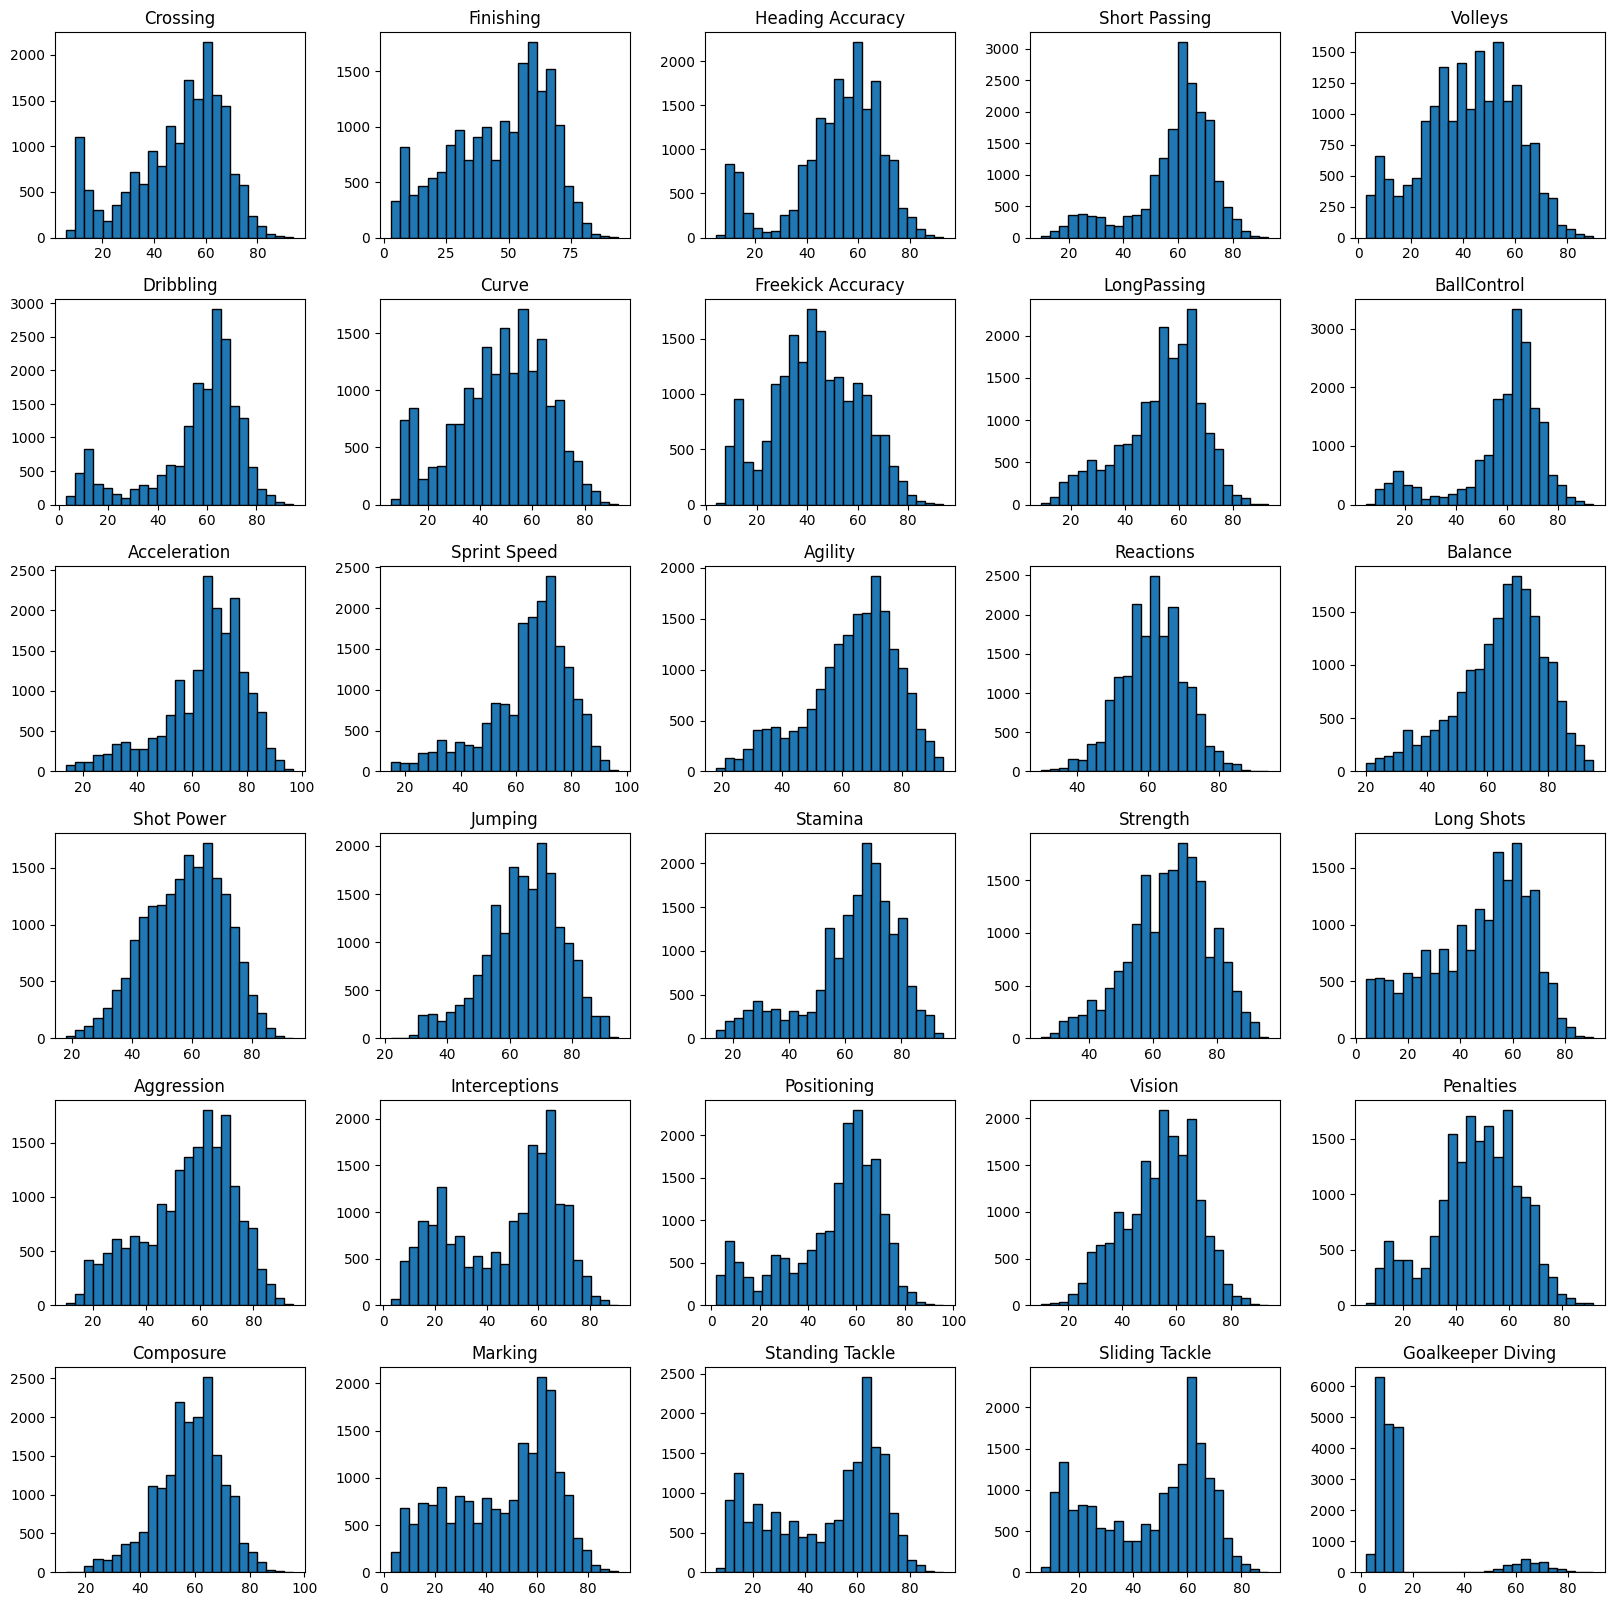

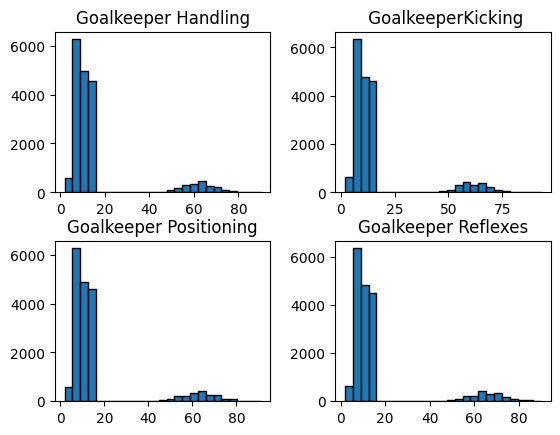

In [8]:
fig, ax = plt.subplots(6, 5, figsize=(20, 20))

display("Distribuição das features sem outliers")
X.iloc[:, 0:30].hist(ax=ax, edgecolor='black', grid=False, bins=25)
X.iloc[:, 30:].hist(edgecolor='black', grid=False, bins=25)
print()

'Distribuição das features sem outliers'

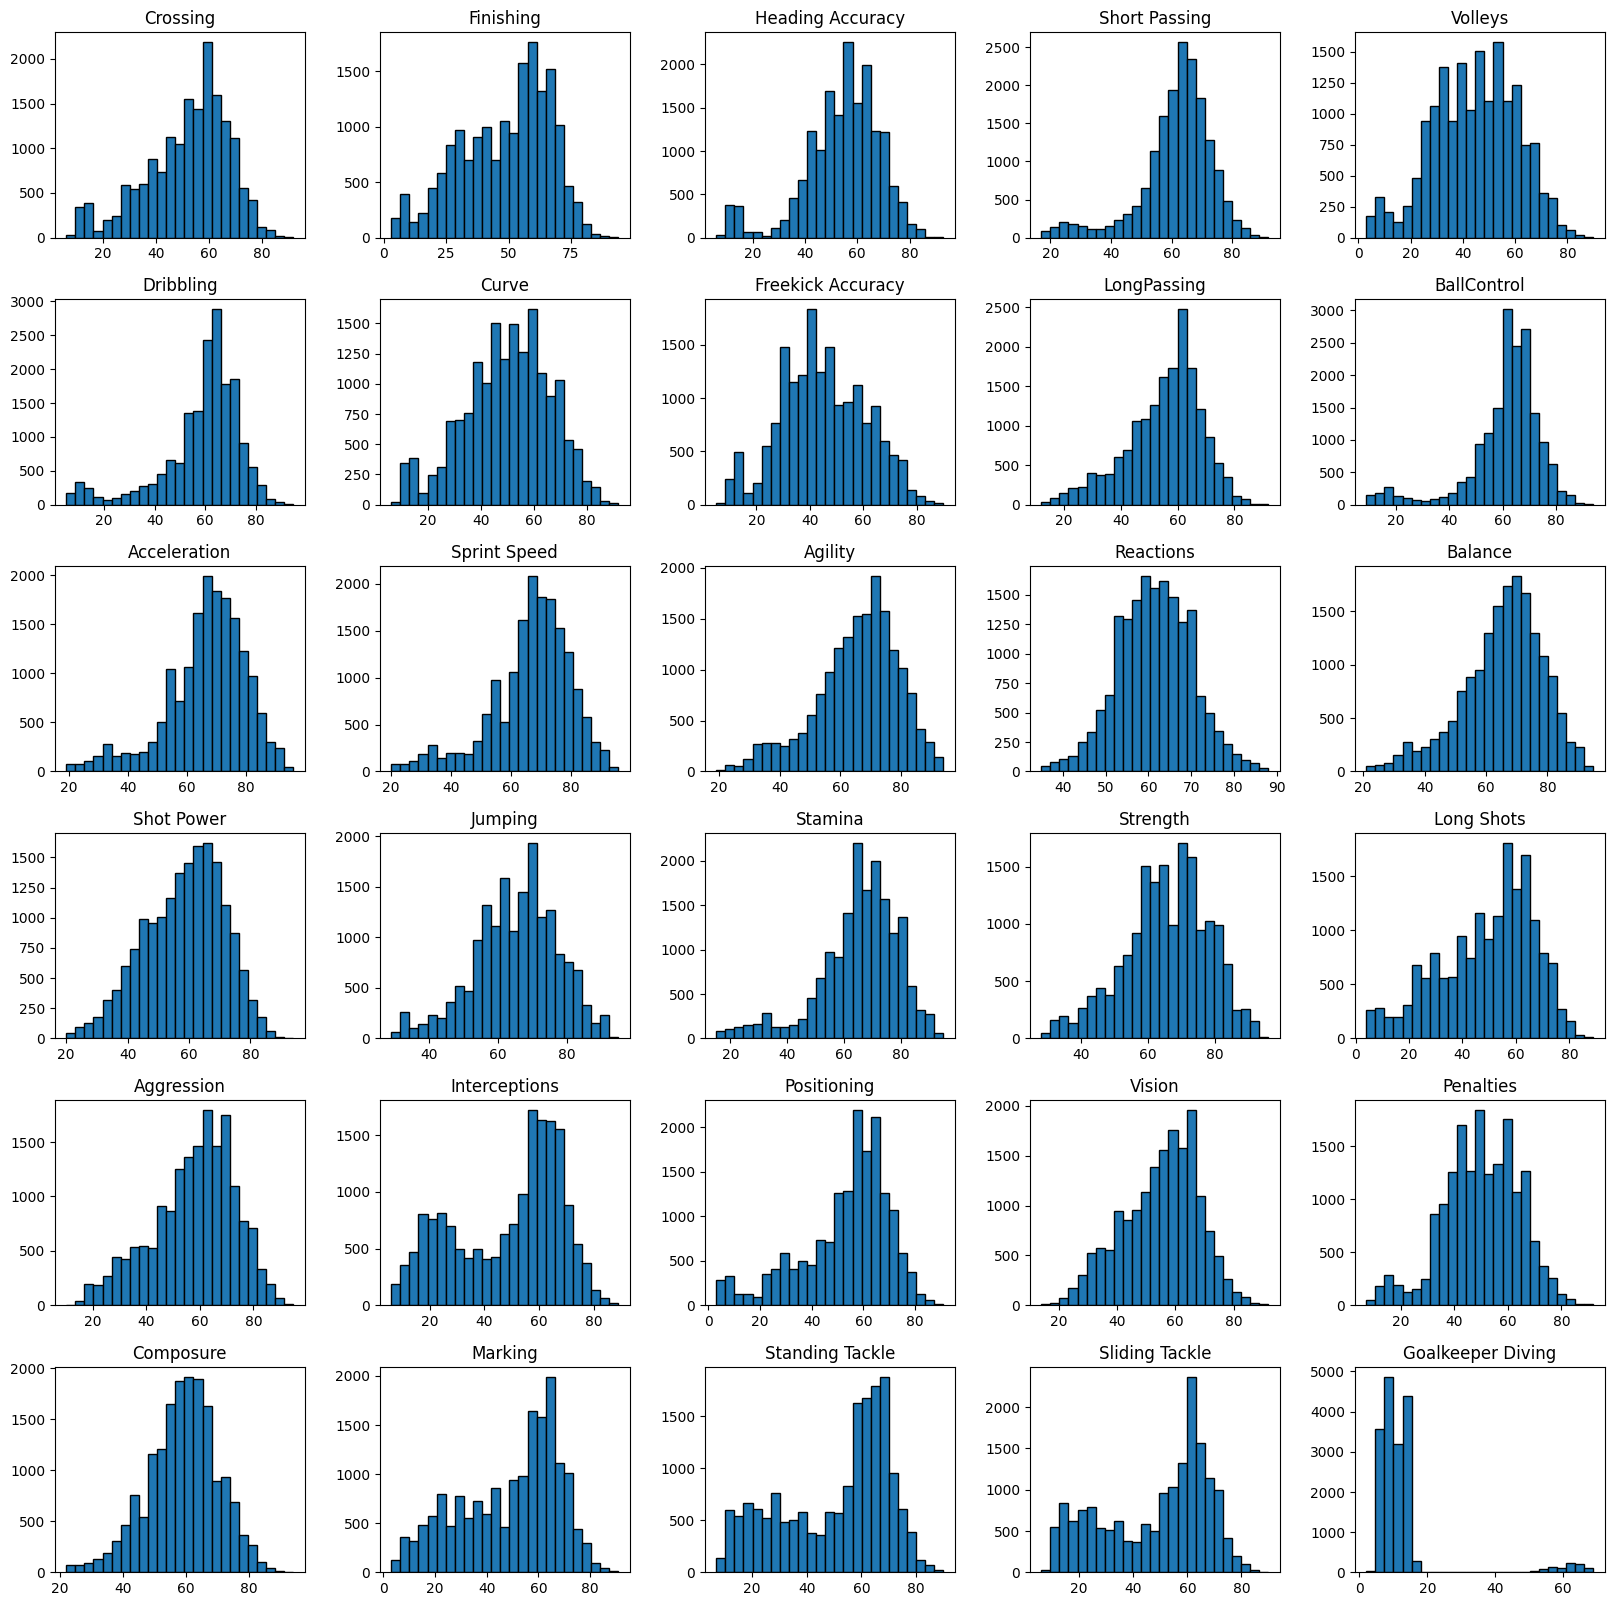

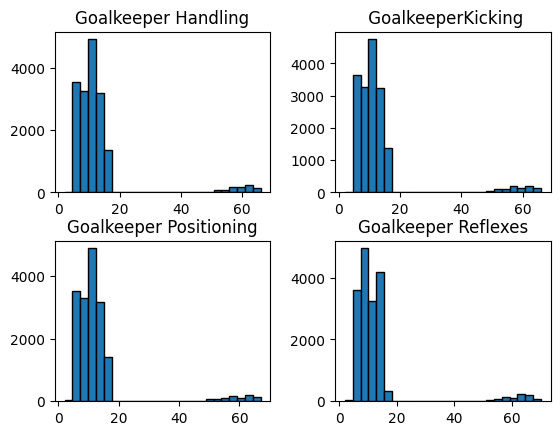

In [9]:
fig, ax = plt.subplots(6, 5, figsize=(20, 20))

display("Distribuição das features sem outliers")

X_.iloc[:, 0:30].hist(ax=ax, edgecolor='black', grid=False, bins=25)
X_.iloc[:, 30:].hist(edgecolor='black', grid=False, bins=25)
print()

Note que a diferença não é tanta e que uma padronização dos dados deve nos dar resultados melhores, visto que alguns dados em si já parecem assumir a forma de uma distribuição normal natural. Como a medida de correlação é invariante sobre escalamento, farei a análise sem padronizar os dados. Note que o target "Best Position" é categórico e, para fazer a comparação, usarei um label encoder. Essa codificação não é a ideal para o treino da rede neural devido a natureza dos valores do target, não há uma ordenação clara, descartando a possibilidade de se usar um label ou ordinal encoder, por exemplo. Aqui utilizarei somente a critério de medir correlações.

## Matrizes de correlação

In [10]:
#tratamento do y
y_label = y_.squeeze()
enc1 = sklp.LabelEncoder()
enc1.fit(y_label)
y_label = enc1.transform(y_label)
y_label[:5]

array([ 8,  2,  2, 14,  0])

In [11]:
def drawCorrelation(corrMatrix, vmax=1): #código de https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    '''
    Recebe uma matriz de correlação e plota
    sua parte triangular inferior.
    Entrada:
        Matriz de correlação;
        valor máximo para a correlação.
    '''
    #filtro para a tudo abaixo da diagonal
    mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
    
    f, ax = plt.subplots(figsize=(11, 9))
    
    # Geração do colormap do gráfico
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    # Desenho da matriz de correlação com o filtro desejado
    sns.heatmap(corrMatrix, mask=mask, cmap=cmap, vmax=vmax, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

def printCorrelation(corrMatrix):
    '''
    Recebe uma matriz de correlação e a plota com
    seus valores númericos.
    Entrada:
        Matriz de correlação
    '''
    display(corrMatrix.style.background_gradient(cmap='coolwarm'))

def filterCorrelation(corrMatrix, value, absolute_all=True):
    '''
    Recebe uma matriz de correlação e um valor limitante,
    toda entrada que seja menor que este valor é zerada. Caso
    absolute_all estaja como True, todas as entradas são convertidas
    para seus respectivos valores absolutos.
    Entrada:
        matriz de correlação;
        valor limitante;
        absolute_all. Se True, converte todos os valores
        da matriz para seus respectivos valores absolutos.
    Saída:
        matriz de correlação filtrada;
        pares de atributos que mantiveram seu valor.
    '''
    lines, columns = corrMatrix.shape
    filteredCorrMatrix = corrMatrix.copy()
    highCorrelations = []
    if absolute_all == True:
        filteredCorrMatrix = filteredCorrMatrix.abs()
    for i in range(lines):
        for j in range(i+1, columns):
            if abs(filteredCorrMatrix.iloc[i, j]) < abs(value):
                filteredCorrMatrix.iloc[i, j] = 0
                filteredCorrMatrix.iloc[j, i] = 0
            else:
                highCorrelations.append((filteredCorrMatrix.columns[i], filteredCorrMatrix.columns[j]))
    return filteredCorrMatrix, highCorrelations

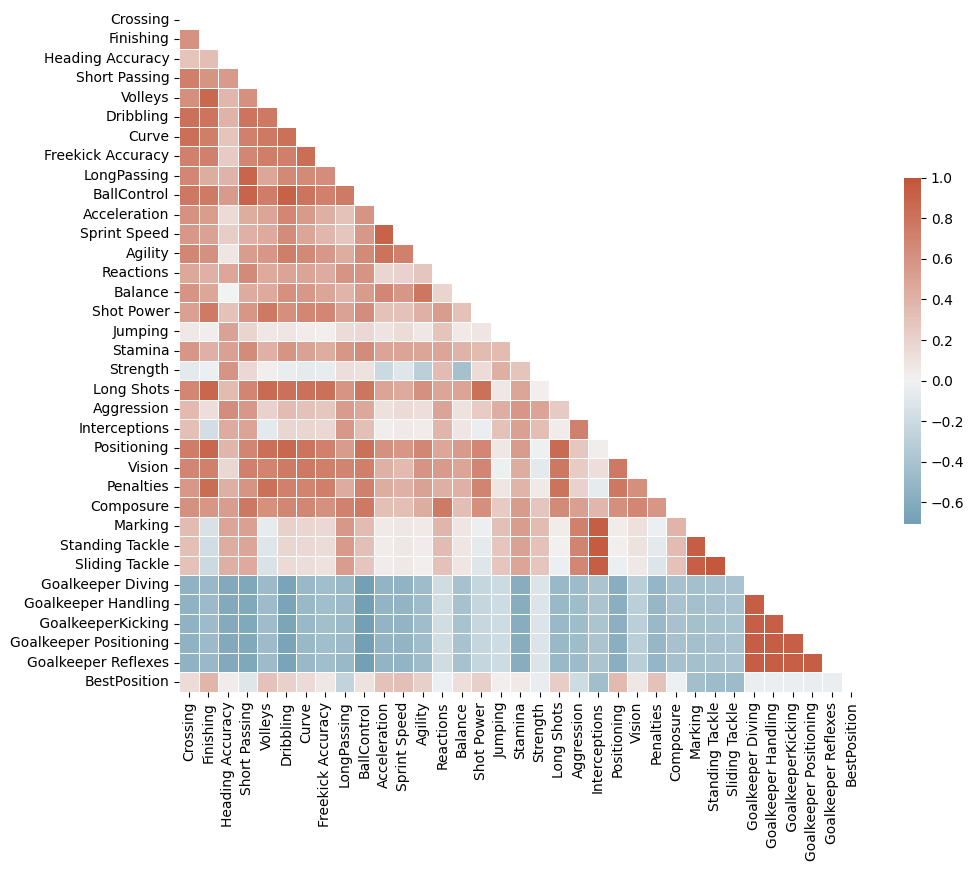

In [12]:
X_correlation = X_.assign(BestPosition=y_label).corr()
drawCorrelation(X_correlation)

In [13]:
printCorrelation(X_correlation)

,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,Freekick Accuracy,LongPassing,BallControl,Acceleration,Sprint Speed,Agility,Reactions,Balance,Shot Power,Jumping,Stamina,Strength,Long Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,Goalkeeper Diving,Goalkeeper Handling,GoalkeeperKicking,Goalkeeper Positioning,Goalkeeper Reflexes,BestPosition
Crossing,1.000000,0.600965,0.288298,0.727081,0.621285,0.815367,0.828825,0.713565,0.674420,0.778654,0.606580,0.560011,0.675263,0.467600,0.589581,0.518921,0.053953,0.571364,-0.075981,0.681921,0.355765,0.325920,0.740948,0.690185,0.564201,0.607771,0.337310,0.321758,0.303935,-0.540171,-0.534982,-0.534078,-0.536436,-0.538881,0.141702
Finishing,0.600965,1.000000,0.333065,0.596419,0.877550,0.799454,0.735046,0.711985,0.441462,0.751656,0.536301,0.501606,0.608622,0.412288,0.478764,0.753794,0.028118,0.410782,-0.024379,0.886191,0.125766,-0.160858,0.882515,0.714332,0.843702,0.578215,-0.141678,-0.176298,-0.215683,-0.481900,-0.478774,-0.472550,-0.477636,-0.480321,0.381810
Heading Accuracy,0.288298,0.333065,1.000000,0.554443,0.371522,0.400209,0.287987,0.256983,0.406157,0.548229,0.153052,0.228917,0.078145,0.477668,-0.006332,0.311501,0.501219,0.510603,0.587661,0.348756,0.636833,0.449560,0.376989,0.171954,0.424734,0.526673,0.485620,0.444527,0.422945,-0.619700,-0.614234,-0.612751,-0.613915,-0.617674,0.037549
Short Passing,0.727081,0.596419,0.554443,1.000000,0.615259,0.794409,0.722117,0.674175,0.889575,0.894513,0.439614,0.418774,0.526693,0.652955,0.448791,0.576242,0.192643,0.642480,0.164706,0.689410,0.563620,0.495923,0.688513,0.715778,0.597583,0.777671,0.511473,0.488498,0.453625,-0.632303,-0.625099,-0.623686,-0.625421,-0.630527,-0.103983
Volleys,0.621285,0.877550,0.371522,0.615259,1.000000,0.766456,0.770402,0.736182,0.477192,0.741666,0.489534,0.456061,0.574633,0.456246,0.457657,0.763905,0.067291,0.406938,0.018363,0.853645,0.198979,-0.077225,0.828581,0.693834,0.821484,0.619074,-0.059832,-0.097808,-0.136310,-0.475086,-0.470772,-0.465651,-0.469884,-0.473543,0.313195
Dribbling,0.815367,0.799454,0.400209,0.794409,0.766456,1.000000,0.823853,0.727158,0.662073,0.919344,0.685860,0.643074,0.739033,0.493798,0.617412,0.630025,0.074491,0.589523,-0.044954,0.812329,0.336958,0.179458,0.879066,0.752579,0.720910,0.676799,0.201318,0.179048,0.150722,-0.664808,-0.661617,-0.657726,-0.660963,-0.664119,0.210175
Curve,0.828825,0.735046,0.287987,0.722117,0.770402,0.823853,1.000000,0.835115,0.655979,0.794219,0.547654,0.491907,0.664220,0.496225,0.562714,0.683238,0.041526,0.506222,-0.062027,0.809421,0.302293,0.173724,0.794012,0.765196,0.698211,0.671033,0.185278,0.160597,0.129686,-0.494433,-0.491311,-0.488551,-0.491284,-0.493700,0.148918
Freekick Accuracy,0.713565,0.711985,0.256983,0.674175,0.736182,0.727158,0.835115,1.000000,0.638469,0.715977,0.422993,0.367219,0.564661,0.452172,0.490738,0.683410,0.013288,0.446508,-0.049492,0.826480,0.267340,0.154576,0.723549,0.731882,0.730392,0.611813,0.158657,0.136431,0.104010,-0.444873,-0.441946,-0.437461,-0.441302,-0.445281,0.063878
LongPassing,0.674420,0.441462,0.406157,0.889575,0.477192,0.662073,0.655979,0.638469,1.000000,0.750207,0.307141,0.277450,0.439423,0.586813,0.393343,0.505129,0.138390,0.569804,0.120896,0.590530,0.541499,0.564247,0.540282,0.698863,0.451678,0.702766,0.566302,0.553776,0.527512,-0.483709,-0.476989,-0.476146,-0.477144,-0.484129,-0.259554
BallControl,0.778654,0.751656,0.548229,0.894513,0.741666,0.919344,0.794219,0.715977,0.750207,1.000000,0.592407,0.565317,0.652788,0.598245,0.540893,0.634449,0.163374,0.643278,0.097796,0.787352,0.469503,0.321000,0.825500,0.728536,0.712017,0.768472,0.346582,0.314929,0.280313,-0.706937,-0.701291,-0.698699,-0.701166,-0.705947,0.099854


### Features correlacionadas entre si

Apesar de nenhuma feature estar fortemente correlacionada com o target "BestPosition", alguns atributos estão fortemente correlacionados entre si, isto pode atrapalhar o modelo, visto que a mesma informação poderia estar sendo considerada mais de uma vez e de nada acrescentaria na interpretabilidade do modelo. Desse modo, retirarei alguns destes atributos e, enfim, os atributos finais que serão usados para teste serão escolhidos. A escolhe de o que é uma correlação alta aqui é ambígua e livre, determinarei que uma alta correlação é possuir um valor acima de 0,70 em módulo.

In [14]:
#limitante superior
threshold = 0.70

#gera matriz de correlação filtrada e os pares de alta correlação
filtered_X_correlation, highCorrelations = filterCorrelation(X_correlation, threshold, True)
printCorrelation(filtered_X_correlation)

print(f"\n\nPares de alta correlação:\n\n")
for pair in highCorrelations:
    print(pair)

,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,Freekick Accuracy,LongPassing,BallControl,Acceleration,Sprint Speed,Agility,Reactions,Balance,Shot Power,Jumping,Stamina,Strength,Long Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,Goalkeeper Diving,Goalkeeper Handling,GoalkeeperKicking,Goalkeeper Positioning,Goalkeeper Reflexes,BestPosition
Crossing,1.000000,0.000000,0.000000,0.727081,0.000000,0.815367,0.828825,0.713565,0.000000,0.778654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.740948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Finishing,0.000000,1.000000,0.000000,0.000000,0.877550,0.799454,0.735046,0.711985,0.000000,0.751656,0.000000,0.000000,0.000000,0.000000,0.000000,0.753794,0.000000,0.000000,0.000000,0.886191,0.000000,0.000000,0.882515,0.714332,0.843702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Heading Accuracy,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Short Passing,0.727081,0.000000,0.000000,1.000000,0.000000,0.794409,0.722117,0.000000,0.889575,0.894513,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.715778,0.000000,0.777671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Volleys,0.000000,0.877550,0.000000,0.000000,1.000000,0.766456,0.770402,0.736182,0.000000,0.741666,0.000000,0.000000,0.000000,0.000000,0.000000,0.763905,0.000000,0.000000,0.000000,0.853645,0.000000,0.000000,0.828581,0.000000,0.821484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Dribbling,0.815367,0.799454,0.000000,0.794409,0.766456,1.000000,0.823853,0.727158,0.000000,0.919344,0.000000,0.000000,0.739033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.812329,0.000000,0.000000,0.879066,0.752579,0.720910,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Curve,0.828825,0.735046,0.000000,0.722117,0.770402,0.823853,1.000000,0.835115,0.000000,0.794219,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.809421,0.000000,0.000000,0.794012,0.765196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Freekick Accuracy,0.713565,0.711985,0.000000,0.000000,0.736182,0.727158,0.835115,1.000000,0.000000,0.715977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.826480,0.000000,0.000000,0.723549,0.731882,0.730392,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LongPassing,0.000000,0.000000,0.000000,0.889575,0.000000,0.000000,0.000000,0.000000,1.000000,0.750207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.702766,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BallControl,0.778654,0.751656,0.000000,0.894513,0.741666,0.919344,0.794219,0.715977,0.750207,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.787352,0.000000,0.000000,0.825500,0.728536,0.712017,0.768472,0.000000,0.000000,0.000000,0.706937,0.701291,0.000000,0.701166,0.705947,0.000000




Pares de alta correlação:


('Crossing', 'Short Passing')
('Crossing', 'Dribbling')
('Crossing', 'Curve')
('Crossing', 'Freekick Accuracy')
('Crossing', 'BallControl')
('Crossing', 'Positioning')
('Finishing', 'Volleys')
('Finishing', 'Dribbling')
('Finishing', 'Curve')
('Finishing', 'Freekick Accuracy')
('Finishing', 'BallControl')
('Finishing', 'Shot Power')
('Finishing', 'Long Shots')
('Finishing', 'Positioning')
('Finishing', 'Vision')
('Finishing', 'Penalties')
('Short Passing', 'Dribbling')
('Short Passing', 'Curve')
('Short Passing', 'LongPassing')
('Short Passing', 'BallControl')
('Short Passing', 'Vision')
('Short Passing', 'Composure')
('Volleys', 'Dribbling')
('Volleys', 'Curve')
('Volleys', 'Freekick Accuracy')
('Volleys', 'BallControl')
('Volleys', 'Shot Power')
('Volleys', 'Long Shots')
('Volleys', 'Positioning')
('Volleys', 'Penalties')
('Dribbling', 'Curve')
('Dribbling', 'Freekick Accuracy')
('Dribbling', 'BallControl')
('Dribbling', 'Agility')
('Dribbling', 'Long Sh

No caso de atributos estarem fortemente correlacionados, mantenho o que possuía maior correlação com o target e que correlação < 0.7 com os atributos já previamente escolhidos. A célula abaixo pega os candidatos a serem atributos escolhidos. A célula seguinte verifica se estes podem, de fato, serem selecionados, no caso de mais de um poder ser, é pego o de maior correlação.

In [15]:
#pega o atributo de maior correlação com BestPosition, exceto o próprio BestPosition
#cuja correlação é 1, para ser o primeiro atributo escolhido
chosen = [X_correlation["BestPosition"][:-1].abs().idxmax()]

#percorre cada coluna da matriz de correlação, exceto a de BestPosition
for i in X_correlation.index[:-1]:

    #filtra todas as colunas cuja correlação seja menor que o limitante superior
    indexes = (abs(X_correlation[chosen]) < threshold).all(axis=1)

    #garante que BestPosition não será selecionado
    indexes["BestPosition"] = False

    #pega os valores de correlação entre os atributos já escolhidos
    #e as colunas previamente filtradas
    att_index = X_correlation[chosen][indexes]

    #caso haja um novo candidato a entrar na "base" de atributos
    #esse if é executado
    if not att_index.empty:
        #pega cada coluna filtrada e sua correlação com BestPosition
        targetCorr = pd.DataFrame(X_correlation["BestPosition"][att_index.index])
        print("correlação de candidatos por atributos já escolhidos\n")
        display(X_correlation[chosen][indexes])
        print("correlação de candidatos com o target\n")
        display(targetCorr)

        #o atributo da matriz filtrada com a maior correlação,
        #em módulo, com BestPosition é selecionado e adicionado
        #à "base"
        att = targetCorr.abs().idxmax().iloc[0]
        print(f"atributo escolhido: {att}")
        chosen.append(att)
        print("-----\n\n")

correlação de candidatos por atributos já escolhidos



,Sliding Tackle
Crossing,0.303935
Finishing,-0.215683
Heading Accuracy,0.422945
Short Passing,0.453625
Volleys,-0.136310
Dribbling,0.150722
Curve,0.129686
Freekick Accuracy,0.104010
LongPassing,0.527512
BallControl,0.280313


correlação de candidatos com o target



,BestPosition
Crossing,0.141702
Finishing,0.381810
Heading Accuracy,0.037549
Short Passing,-0.103983
Volleys,0.313195
Dribbling,0.210175
Curve,0.148918
Freekick Accuracy,0.063878
LongPassing,-0.259554
BallControl,0.099854


atributo escolhido: Finishing
-----


correlação de candidatos por atributos já escolhidos



,Sliding Tackle,Finishing
Crossing,0.303935,0.600965
Heading Accuracy,0.422945,0.333065
Short Passing,0.453625,0.596419
LongPassing,0.527512,0.441462
Acceleration,0.036458,0.536301
Sprint Speed,0.054117,0.501606
Agility,0.020127,0.608622
Reactions,0.299773,0.412288
Balance,0.073266,0.478764
Jumping,0.284397,0.028118


correlação de candidatos com o target



,BestPosition
Crossing,0.141702
Heading Accuracy,0.037549
Short Passing,-0.103983
LongPassing,-0.259554
Acceleration,0.303559
Sprint Speed,0.319832
Agility,0.215699
Reactions,-0.022556
Balance,0.122588
Jumping,0.013759


atributo escolhido: Sprint Speed
-----


correlação de candidatos por atributos já escolhidos



,Sliding Tackle,Finishing,Sprint Speed
Crossing,0.303935,0.600965,0.560011
Heading Accuracy,0.422945,0.333065,0.228917
Short Passing,0.453625,0.596419,0.418774
LongPassing,0.527512,0.441462,0.277450
Reactions,0.299773,0.412288,0.195078
Balance,0.073266,0.478764,0.572231
Jumping,0.284397,0.028118,0.134946
Stamina,0.481262,0.410782,0.499659
Strength,0.283475,-0.024379,-0.104467
Aggression,0.680514,0.125766,0.147522


correlação de candidatos com o target



,BestPosition
Crossing,0.141702
Heading Accuracy,0.037549
Short Passing,-0.103983
LongPassing,-0.259554
Reactions,-0.022556
Balance,0.122588
Jumping,0.013759
Stamina,0.050981
Strength,-0.043884
Aggression,-0.198873


atributo escolhido: LongPassing
-----


correlação de candidatos por atributos já escolhidos



,Sliding Tackle,Finishing,Sprint Speed,LongPassing
Crossing,0.303935,0.600965,0.560011,0.674420
Heading Accuracy,0.422945,0.333065,0.228917,0.406157
Reactions,0.299773,0.412288,0.195078,0.586813
Balance,0.073266,0.478764,0.572231,0.393343
Jumping,0.284397,0.028118,0.134946,0.138390
Stamina,0.481262,0.410782,0.499659,0.569804
Strength,0.283475,-0.024379,-0.104467,0.120896
Aggression,0.680514,0.125766,0.147522,0.541499
Goalkeeper Diving,-0.399801,-0.481900,-0.527449,-0.483709
Goalkeeper Handling,-0.396422,-0.478774,-0.525600,-0.476989


correlação de candidatos com o target



,BestPosition
Crossing,0.141702
Heading Accuracy,0.037549
Reactions,-0.022556
Balance,0.122588
Jumping,0.013759
Stamina,0.050981
Strength,-0.043884
Aggression,-0.198873
Goalkeeper Diving,-0.038538
Goalkeeper Handling,-0.038699


atributo escolhido: Aggression
-----


correlação de candidatos por atributos já escolhidos



,Sliding Tackle,Finishing,Sprint Speed,LongPassing,Aggression
Crossing,0.303935,0.600965,0.560011,0.674420,0.355765
Heading Accuracy,0.422945,0.333065,0.228917,0.406157,0.636833
Reactions,0.299773,0.412288,0.195078,0.586813,0.498103
Balance,0.073266,0.478764,0.572231,0.393343,0.094047
Jumping,0.284397,0.028118,0.134946,0.138390,0.430098
Stamina,0.481262,0.410782,0.499659,0.569804,0.577853
Strength,0.283475,-0.024379,-0.104467,0.120896,0.499689
Goalkeeper Diving,-0.399801,-0.481900,-0.527449,-0.483709,-0.468931
Goalkeeper Handling,-0.396422,-0.478774,-0.525600,-0.476989,-0.464646
GoalkeeperKicking,-0.401716,-0.472550,-0.521447,-0.476146,-0.466654


correlação de candidatos com o target



,BestPosition
Crossing,0.141702
Heading Accuracy,0.037549
Reactions,-0.022556
Balance,0.122588
Jumping,0.013759
Stamina,0.050981
Strength,-0.043884
Goalkeeper Diving,-0.038538
Goalkeeper Handling,-0.038699
GoalkeeperKicking,-0.034792


atributo escolhido: Crossing
-----


correlação de candidatos por atributos já escolhidos



,Sliding Tackle,Finishing,Sprint Speed,LongPassing,Aggression,Crossing
Heading Accuracy,0.422945,0.333065,0.228917,0.406157,0.636833,0.288298
Reactions,0.299773,0.412288,0.195078,0.586813,0.498103,0.467600
Balance,0.073266,0.478764,0.572231,0.393343,0.094047,0.589581
Jumping,0.284397,0.028118,0.134946,0.138390,0.430098,0.053953
Stamina,0.481262,0.410782,0.499659,0.569804,0.577853,0.571364
Strength,0.283475,-0.024379,-0.104467,0.120896,0.499689,-0.075981
Goalkeeper Diving,-0.399801,-0.481900,-0.527449,-0.483709,-0.468931,-0.540171
Goalkeeper Handling,-0.396422,-0.478774,-0.525600,-0.476989,-0.464646,-0.534982
GoalkeeperKicking,-0.401716,-0.472550,-0.521447,-0.476146,-0.466654,-0.534078
Goalkeeper Positioning,-0.397551,-0.477636,-0.524313,-0.477144,-0.464375,-0.536436


correlação de candidatos com o target



,BestPosition
Heading Accuracy,0.037549
Reactions,-0.022556
Balance,0.122588
Jumping,0.013759
Stamina,0.050981
Strength,-0.043884
Goalkeeper Diving,-0.038538
Goalkeeper Handling,-0.038699
GoalkeeperKicking,-0.034792
Goalkeeper Positioning,-0.040176


atributo escolhido: Balance
-----


correlação de candidatos por atributos já escolhidos



,Sliding Tackle,Finishing,Sprint Speed,LongPassing,Aggression,Crossing,Balance
Heading Accuracy,0.422945,0.333065,0.228917,0.406157,0.636833,0.288298,-0.006332
Reactions,0.299773,0.412288,0.195078,0.586813,0.498103,0.467600,0.186849
Jumping,0.284397,0.028118,0.134946,0.138390,0.430098,0.053953,0.050349
Stamina,0.481262,0.410782,0.499659,0.569804,0.577853,0.571364,0.400468
Strength,0.283475,-0.024379,-0.104467,0.120896,0.499689,-0.075981,-0.420513
Goalkeeper Diving,-0.399801,-0.481900,-0.527449,-0.483709,-0.468931,-0.540171,-0.418249
Goalkeeper Handling,-0.396422,-0.478774,-0.525600,-0.476989,-0.464646,-0.534982,-0.417064
GoalkeeperKicking,-0.401716,-0.472550,-0.521447,-0.476146,-0.466654,-0.534078,-0.412655
Goalkeeper Positioning,-0.397551,-0.477636,-0.524313,-0.477144,-0.464375,-0.536436,-0.412263
Goalkeeper Reflexes,-0.400636,-0.480321,-0.525994,-0.484129,-0.468457,-0.538881,-0.415124


correlação de candidatos com o target



,BestPosition
Heading Accuracy,0.037549
Reactions,-0.022556
Jumping,0.013759
Stamina,0.050981
Strength,-0.043884
Goalkeeper Diving,-0.038538
Goalkeeper Handling,-0.038699
GoalkeeperKicking,-0.034792
Goalkeeper Positioning,-0.040176
Goalkeeper Reflexes,-0.036178


atributo escolhido: Stamina
-----


correlação de candidatos por atributos já escolhidos



,Sliding Tackle,Finishing,Sprint Speed,LongPassing,Aggression,Crossing,Balance,Stamina
Heading Accuracy,0.422945,0.333065,0.228917,0.406157,0.636833,0.288298,-0.006332,0.510603
Reactions,0.299773,0.412288,0.195078,0.586813,0.498103,0.467600,0.186849,0.481615
Jumping,0.284397,0.028118,0.134946,0.138390,0.430098,0.053953,0.050349,0.347537
Strength,0.283475,-0.024379,-0.104467,0.120896,0.499689,-0.075981,-0.420513,0.286858
Goalkeeper Diving,-0.399801,-0.481900,-0.527449,-0.483709,-0.468931,-0.540171,-0.418249,-0.591190
Goalkeeper Handling,-0.396422,-0.478774,-0.525600,-0.476989,-0.464646,-0.534982,-0.417064,-0.586049
GoalkeeperKicking,-0.401716,-0.472550,-0.521447,-0.476146,-0.466654,-0.534078,-0.412655,-0.584000
Goalkeeper Positioning,-0.397551,-0.477636,-0.524313,-0.477144,-0.464375,-0.536436,-0.412263,-0.585560
Goalkeeper Reflexes,-0.400636,-0.480321,-0.525994,-0.484129,-0.468457,-0.538881,-0.415124,-0.590049


correlação de candidatos com o target



,BestPosition
Heading Accuracy,0.037549
Reactions,-0.022556
Jumping,0.013759
Strength,-0.043884
Goalkeeper Diving,-0.038538
Goalkeeper Handling,-0.038699
GoalkeeperKicking,-0.034792
Goalkeeper Positioning,-0.040176
Goalkeeper Reflexes,-0.036178


atributo escolhido: Strength
-----


correlação de candidatos por atributos já escolhidos



,Sliding Tackle,Finishing,Sprint Speed,LongPassing,Aggression,Crossing,Balance,Stamina,Strength
Heading Accuracy,0.422945,0.333065,0.228917,0.406157,0.636833,0.288298,-0.006332,0.510603,0.587661
Reactions,0.299773,0.412288,0.195078,0.586813,0.498103,0.467600,0.186849,0.481615,0.333662
Jumping,0.284397,0.028118,0.134946,0.138390,0.430098,0.053953,0.050349,0.347537,0.424739
Goalkeeper Diving,-0.399801,-0.481900,-0.527449,-0.483709,-0.468931,-0.540171,-0.418249,-0.591190,-0.121249
Goalkeeper Handling,-0.396422,-0.478774,-0.525600,-0.476989,-0.464646,-0.534982,-0.417064,-0.586049,-0.118998
GoalkeeperKicking,-0.401716,-0.472550,-0.521447,-0.476146,-0.466654,-0.534078,-0.412655,-0.584000,-0.120126
Goalkeeper Positioning,-0.397551,-0.477636,-0.524313,-0.477144,-0.464375,-0.536436,-0.412263,-0.585560,-0.119843
Goalkeeper Reflexes,-0.400636,-0.480321,-0.525994,-0.484129,-0.468457,-0.538881,-0.415124,-0.590049,-0.120287


correlação de candidatos com o target



,BestPosition
Heading Accuracy,0.037549
Reactions,-0.022556
Jumping,0.013759
Goalkeeper Diving,-0.038538
Goalkeeper Handling,-0.038699
GoalkeeperKicking,-0.034792
Goalkeeper Positioning,-0.040176
Goalkeeper Reflexes,-0.036178


atributo escolhido: Goalkeeper Positioning
-----


correlação de candidatos por atributos já escolhidos



,Sliding Tackle,Finishing,Sprint Speed,LongPassing,Aggression,Crossing,Balance,Stamina,Strength,Goalkeeper Positioning
Heading Accuracy,0.422945,0.333065,0.228917,0.406157,0.636833,0.288298,-0.006332,0.510603,0.587661,-0.613915
Reactions,0.299773,0.412288,0.195078,0.586813,0.498103,0.467600,0.186849,0.481615,0.333662,-0.186207
Jumping,0.284397,0.028118,0.134946,0.138390,0.430098,0.053953,0.050349,0.347537,0.424739,-0.197226


correlação de candidatos com o target



,BestPosition
Heading Accuracy,0.037549
Reactions,-0.022556
Jumping,0.013759


atributo escolhido: Heading Accuracy
-----


correlação de candidatos por atributos já escolhidos



,Sliding Tackle,Finishing,Sprint Speed,LongPassing,Aggression,Crossing,Balance,Stamina,Strength,Goalkeeper Positioning,Heading Accuracy
Reactions,0.299773,0.412288,0.195078,0.586813,0.498103,0.467600,0.186849,0.481615,0.333662,-0.186207,0.477668
Jumping,0.284397,0.028118,0.134946,0.138390,0.430098,0.053953,0.050349,0.347537,0.424739,-0.197226,0.501219


correlação de candidatos com o target



,BestPosition
Reactions,-0.022556
Jumping,0.013759


atributo escolhido: Reactions
-----


correlação de candidatos por atributos já escolhidos



,Sliding Tackle,Finishing,Sprint Speed,LongPassing,Aggression,Crossing,Balance,Stamina,Strength,Goalkeeper Positioning,Heading Accuracy,Reactions
Jumping,0.284397,0.028118,0.134946,0.13839,0.430098,0.053953,0.050349,0.347537,0.424739,-0.197226,0.501219,0.290716


correlação de candidatos com o target



,BestPosition
Jumping,0.013759


atributo escolhido: Jumping
-----




Com isso, os atributos selecionados foram

In [16]:
chosen_attributes = list(X_correlation[chosen][[False] * X_correlation.shape[0]])
pd.DataFrame(chosen_attributes, columns=["Atributos selecionados"])

,Atributos selecionados
0,Sliding Tackle
1,Finishing
2,Sprint Speed
3,LongPassing
4,Aggression
5,Crossing
6,Balance
7,Stamina
8,Strength
9,Goalkeeper Positioning


## Criação da matriz de input

Com os atributos de entrada definidos, a matriz de input pode ser devidamente formada e tratada. Em seguida, um codificação One Hot é feito na feature do target, onde para $n$ categorias, um vetor de $n$ posições é criado com todas as entradas zeradas exceto uma, que representará a classe daquela instância. Essa escolha é feita visto que as posições não são exatamente ordenadas, tornando menos "viável" opções como codificação ordinal ou por label.

No caso de _foot_, por só possuir duas opções possíveis, pode ser utilizada uma codificação ordinal, já que se comporta como uma variável binária.

In [17]:
X_input = X_[chosen_attributes]
display(X_input)

#tratamento do y
enc1 = sklp.OneHotEncoder(sparse_output=False)
enc1.fit(y_)
y_output = enc1.transform(y_)

#tratando foot
enc2 = sklp.OrdinalEncoder()
enc2.fit(foot)
foot = enc2.transform(foot)

,Sliding Tackle,Finishing,Sprint Speed,LongPassing,Aggression,Crossing,Balance,Stamina,Strength,Goalkeeper Positioning,Heading Accuracy,Reactions,Jumping
Known As,,,,,,,,,,,,,
Neymar Jr,29,83,86,81,63,84,82,79,52,15,63,88,62
Casemiro,87,64,66,83,91,58,66,90,90,12,79,87,85
J. Kimmich,78,68,60,90,89,91,84,94,68,15,72,88,79
E. Haaland,29,94,94,53,85,47,72,81,93,11,79,88,74
Bernardo Silva,53,79,71,77,75,85,92,93,54,12,51,87,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
D. Collins,27,49,68,33,37,40,63,32,31,13,30,44,45
Yang Dejiang,52,33,57,45,52,34,80,34,35,8,44,51,55
L. Mullan,48,36,59,52,39,41,73,36,31,7,42,49,54


In [18]:
y_output

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
X_input = np.column_stack((X_input, foot))
X_input

array([[29., 83., 86., ..., 88., 62.,  1.],
       [87., 64., 66., ..., 87., 85.,  1.],
       [78., 68., 60., ..., 88., 79.,  1.],
       ...,
       [48., 36., 59., ..., 49., 54.,  1.],
       [54., 20., 51., ..., 43., 72.,  1.],
       [43., 28., 53., ..., 45., 66.,  0.]])

## Quebra do conjunto de treino e testes com diferentes arquiteturas e funções de ativação

Aqui testamos diferentes arquiteturas e funções de ativação. A ideia é, dada uma arquitetura, treiná-la por algumas épocas com as funções de ativação sigmoid, tangente hiperbólica e ReLU. Utilizamos a função de perda de entropia categórica cruzada, o "from_logits" diz respeito ao dado "cru", isto é, o fato de o output não ter passado por uma função de softmax, por exemplo.

In [20]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_input, y_output,
                                        test_size=test_size, stratify=y_output,
                                        random_state=8)

fold 1 começou
fold 2 começou
fold 3 começou
fold 4 começou
fold 5 começou
Config das camadas escondidas (cada elemento é o número de neurônios em cada camada escondida:
 [1]


Logística:
Fold 0 acurácia do treino: 0.25448688864707947         	 acurácia de validação: 0.256857767701149
Fold 1 acurácia do treino: 0.33555938601493834         	 acurácia de validação: 0.34651669561862947
Fold 2 acurácia do treino: 0.31232081055641175         	 acurácia de validação: 0.32127041518688204
Fold 3 acurácia do treino: 0.26721103191375734         	 acurácia de validação: 0.27876587510108947
Fold 4 acurácia do treino: 0.27151152193546296         	 acurácia de validação: 0.26261342912912367
média das acurácias de treino dos folds = 0.28821792781352995 	     folds val_accuracies mean = 0.2932048365473747


Tanh:
Fold 0 acurácia do treino: 0.342192180454731         	 acurácia de validação: 0.3652394741773605
Fold 1 acurácia do treino: 0.32633154541254045         	 acurácia de validação: 0.339404928684

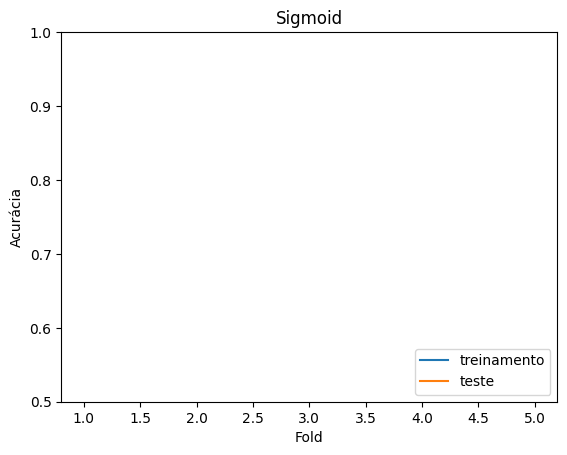

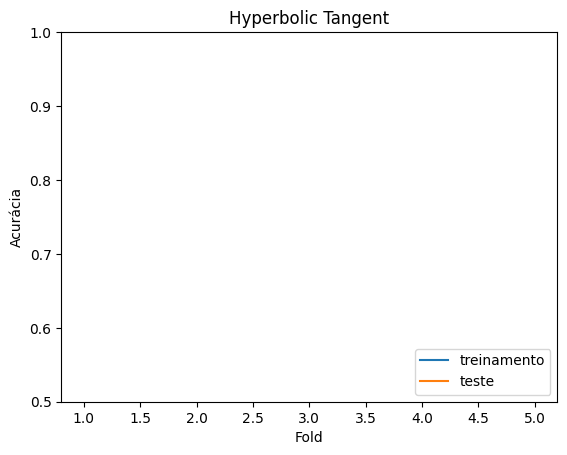

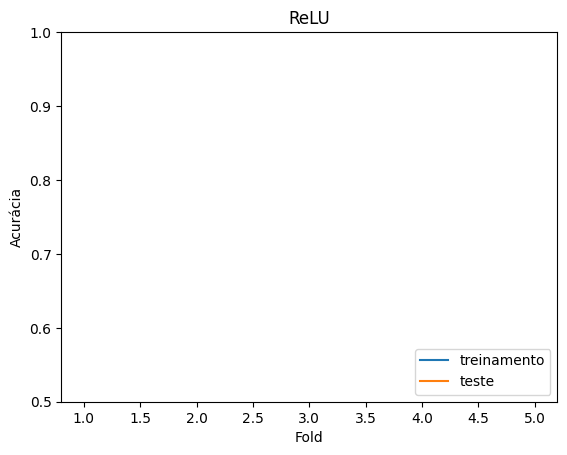

In [21]:
hiddenLayers = [1]
calculate(X_train, y_train, 5, hiddenLayers, X_train.shape[1], 15, 10, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True))

fold 1 começou
fold 2 começou
fold 3 começou
fold 4 começou
fold 5 começou
Config das camadas escondidas (cada elemento é o número de neurônios em cada camada escondida:
 [5, 5, 3, 5, 5]


Logística:
Fold 0 acurácia do treino: 0.20399237424135208         	 acurácia de validação: 0.2104499340057373
Fold 1 acurácia do treino: 0.19935577362775803         	 acurácia de validação: 0.22278665006160736
Fold 2 acurácia do treino: 0.20886408686637878         	 acurácia de validação: 0.20435571670532227
Fold 3 acurácia do treino: 0.20208673924207687         	 acurácia de validação: 0.21851179003715515
Fold 4 acurácia do treino: 0.21140446662902831         	 acurácia de validação: 0.19709618389606476
média das acurácias de treino dos folds = 0.20514068812131883 	     folds val_accuracies mean = 0.21064005494117738


Tanh:
Fold 0 acurácia do treino: 0.4678069084882736         	 acurácia de validação: 0.4894775003194809
Fold 1 acurácia do treino: 0.45014971792697905         	 acurácia de validação:

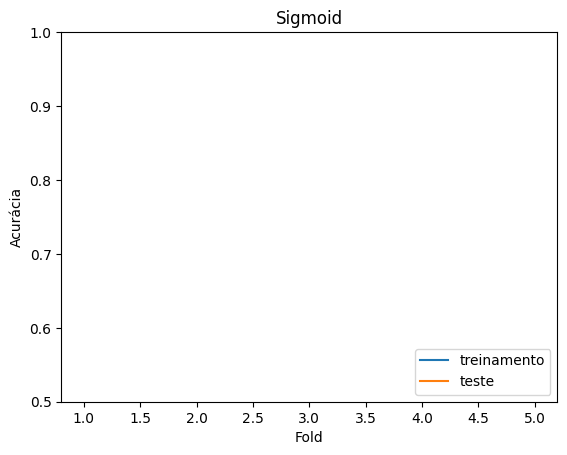

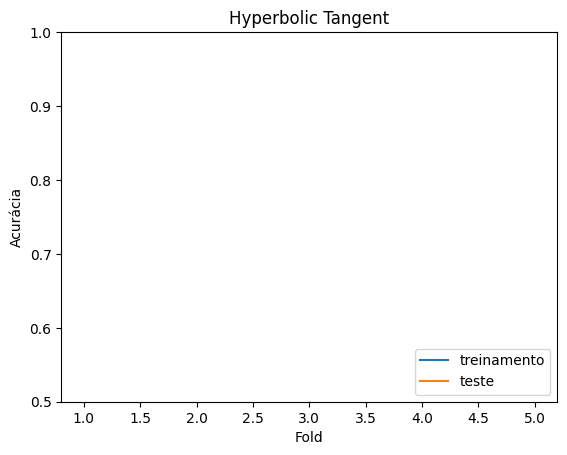

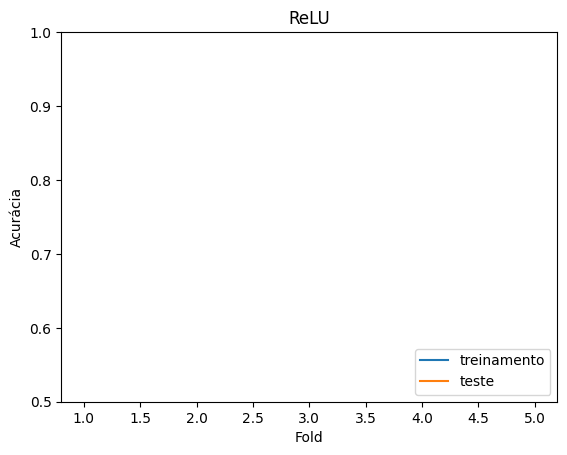

In [22]:
hiddenLayers = [5, 5, 3, 5, 5]
calculate(X_train, y_train, 5, hiddenLayers, X_train.shape[1], 15, 10, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True))

fold 1 começou
fold 2 começou
fold 3 começou
fold 4 começou
fold 5 começou
Config das camadas escondidas (cada elemento é o número de neurônios em cada camada escondida:
 [10, 5, 10]


Logística:
Fold 0 acurácia do treino: 0.2015425056219101         	 acurácia de validação: 0.2104499340057373
Fold 1 acurácia do treino: 0.19953724443912507         	 acurácia de validação: 0.22278665006160736
Fold 2 acurácia do treino: 0.20516240000724792         	 acurácia de validação: 0.20435571670532227
Fold 3 acurácia do treino: 0.2058700814843178         	 acurácia de validação: 0.21851179003715515
Fold 4 acurácia do treino: 0.21243876218795776         	 acurácia de validação: 0.19709618389606476
média das acurácias de treino dos folds = 0.20491019874811173 	     folds val_accuracies mean = 0.21064005494117738


Tanh:
Fold 0 acurácia do treino: 0.5168405830860138         	 acurácia de validação: 0.5324383080005646
Fold 1 acurácia do treino: 0.5494691997766494         	 acurácia de validação: 0.5674

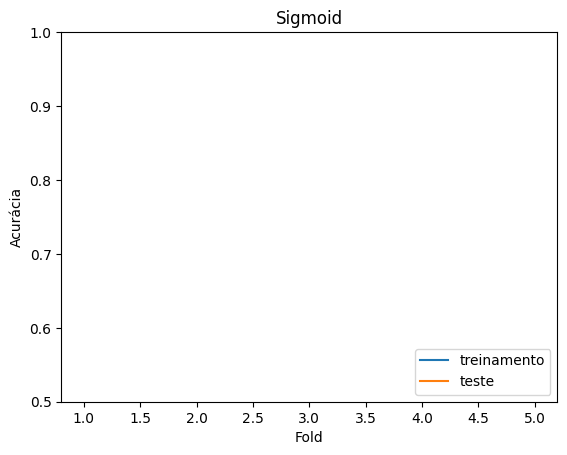

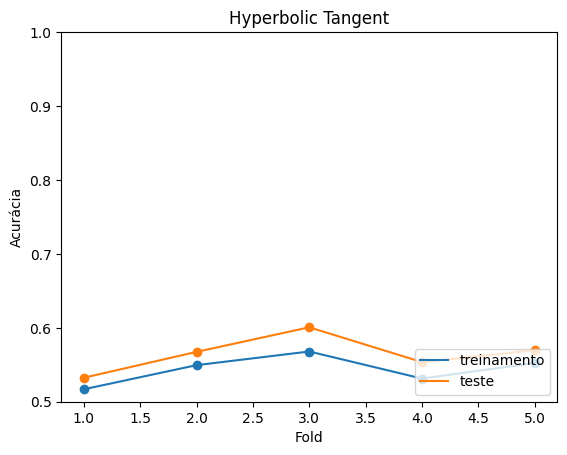

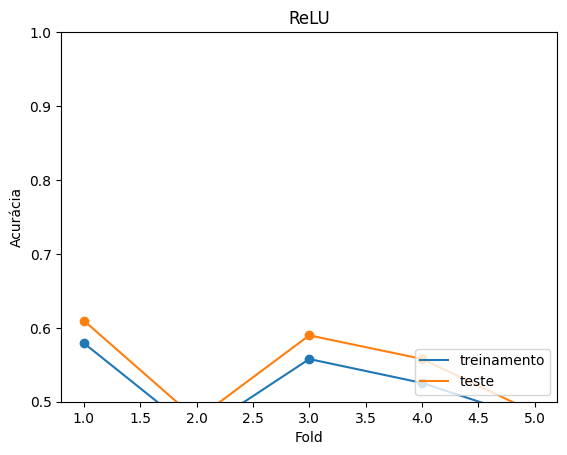

In [23]:
hiddenLayers = [10, 5, 10]
calculate(X_train, y_train, 5, hiddenLayers, X_train.shape[1], 15, 10, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True))

fold 1 começou
fold 2 começou
fold 3 começou
fold 4 começou
fold 5 começou
Config das camadas escondidas (cada elemento é o número de neurônios em cada camada escondida:
 [32, 64, 32]


Logística:
Fold 0 acurácia do treino: 0.2081299290060997         	 acurácia de validação: 0.2104499340057373
Fold 1 acurácia do treino: 0.20544414967298508         	 acurácia de validação: 0.22278665006160736
Fold 2 acurácia do treino: 0.21017056554555893         	 acurácia de validação: 0.20435571670532227
Fold 3 acurácia do treino: 0.20682272166013718         	 acurácia de validação: 0.21851179003715515
Fold 4 acurácia do treino: 0.21213936060667038         	 acurácia de validação: 0.19709618389606476
média das acurácias de treino dos folds = 0.20854134529829027 	     folds val_accuracies mean = 0.21064005494117738


Tanh:
Fold 0 acurácia do treino: 0.6864168286323548         	 acurácia de validação: 0.7080914437770843
Fold 1 acurácia do treino: 0.6896651774644852         	 acurácia de validação: 0.70

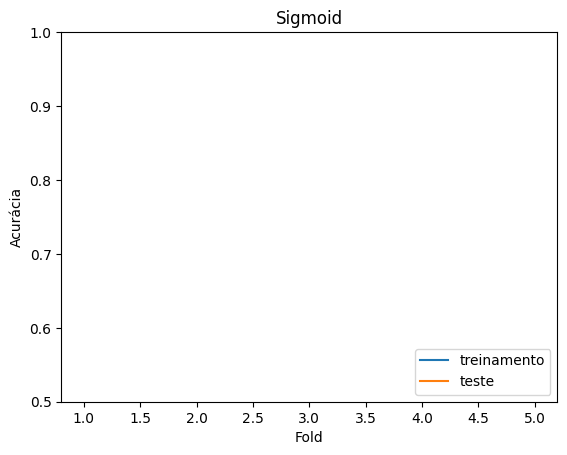

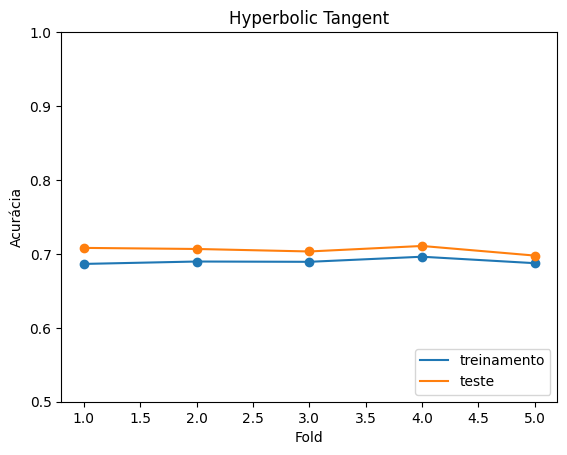

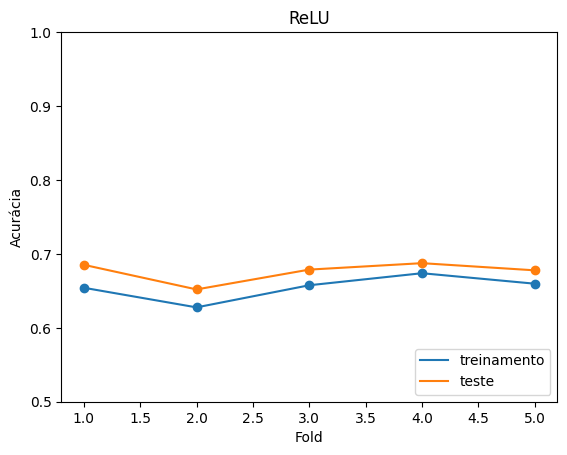

In [24]:
hiddenLayers = [32, 64, 32]
calculate(X_train, y_train, 5, hiddenLayers, X_train.shape[1], 15, 10, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True))

fold 1 começou
fold 2 começou
fold 3 começou
fold 4 começou
fold 5 começou
Config das camadas escondidas (cada elemento é o número de neurônios em cada camada escondida:
 [16, 32, 64, 32, 16]


Logística:
Fold 0 acurácia do treino: 0.2055802509188652         	 acurácia de validação: 0.2104499340057373
Fold 1 acurácia do treino: 0.20305779576301575         	 acurácia de validação: 0.22278665006160736
Fold 2 acurácia do treino: 0.20919978022575378         	 acurácia de validação: 0.20435571670532227
Fold 3 acurácia do treino: 0.20462711304426193         	 acurácia de validação: 0.21851179003715515
Fold 4 acurácia do treino: 0.2135728567838669         	 acurácia de validação: 0.19709618389606476
média das acurácias de treino dos folds = 0.20720755934715274 	     folds val_accuracies mean = 0.21064005494117738


Tanh:
Fold 0 acurácia do treino: 0.6435350686311722         	 acurácia de validação: 0.6757982432842254
Fold 1 acurácia do treino: 0.6631340175867081         	 acurácia de validaçã

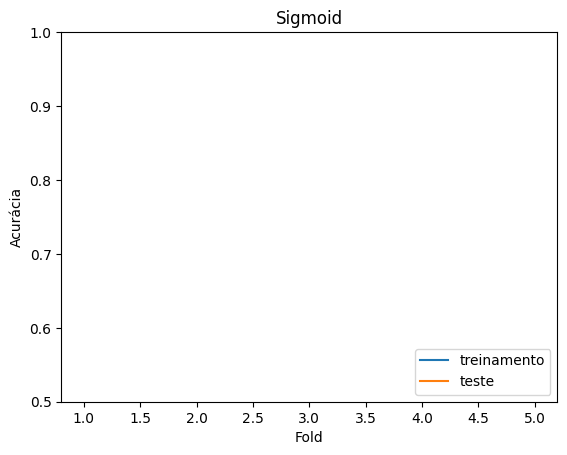

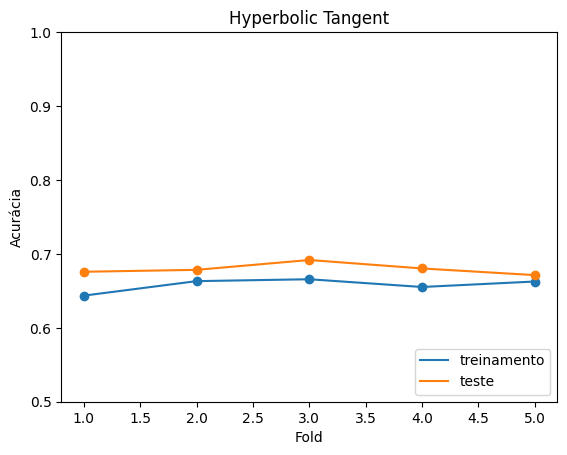

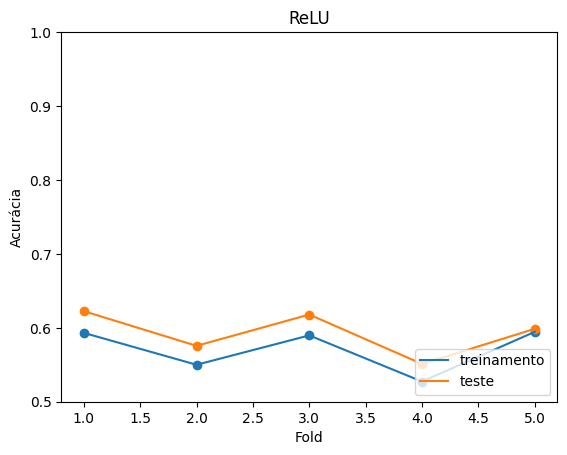

In [25]:
hiddenLayers = [16, 32, 64, 32, 16]
calculate(X_train, y_train, 5, hiddenLayers, X_train.shape[1], 15, 10, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True))

## Teste com a melhor arquitetura

Note que o ganho de precisão da arquitetura [32, 64, 32] para a [16, 32, 64, 32, 16] é pequena, então optaremos para a mais simples.

In [26]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_input, y_output,
                                        test_size=test_size, stratify=y_output,
                                        random_state=8)
X_train_, X_test_, scaler = standardData(X_train, X_test)

Epoch 1/10
431/431 [==============================] - 2s 3ms/step - loss: 1.6024 - accuracy: 0.5392 - val_loss: 1.1586 - val_accuracy: 0.6459
Epoch 2/10
431/431 [==============================] - 1s 3ms/step - loss: 1.0134 - accuracy: 0.6875 - val_loss: 0.9366 - val_accuracy: 0.7100
Epoch 3/10
431/431 [==============================] - 2s 4ms/step - loss: 0.8760 - accuracy: 0.7168 - val_loss: 0.8535 - val_accuracy: 0.7263
Epoch 4/10
431/431 [==============================] - 1s 3ms/step - loss: 0.8162 - accuracy: 0.7288 - val_loss: 0.8120 - val_accuracy: 0.7321
Epoch 5/10
431/431 [==============================] - 2s 4ms/step - loss: 0.7834 - accuracy: 0.7340 - val_loss: 0.7901 - val_accuracy: 0.7303
Epoch 6/10
431/431 [==============================] - 1s 3ms/step - loss: 0.7636 - accuracy: 0.7349 - val_loss: 0.7720 - val_accuracy: 0.7321
Epoch 7/10
431/431 [==============================] - 1s 3ms/step - loss: 0.7495 - accuracy: 0.7396 - val_loss: 0.7622 - val_accuracy: 0.7321
Epoch 

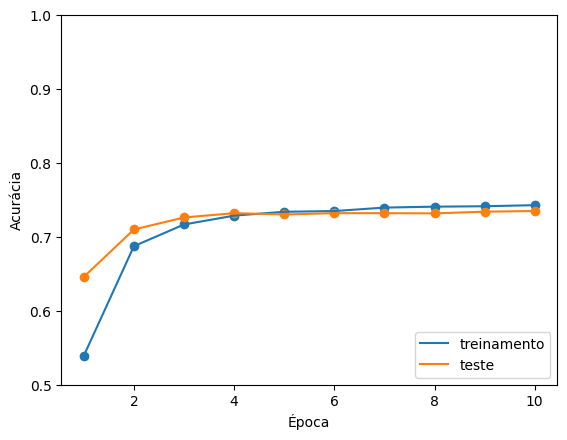

In [27]:
hiddenLayers = [32, 64, 32]
neuralNetwork, history, testLoss, testAccuracy = testModel(X_train_, y_train, X_test_, y_test, verbose=1, ls=hiddenLayers, input=X_input.shape[1],
          output=15, activation="tanh", optimizer="sgd",
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'], epochs=30)

plotHistory(history)

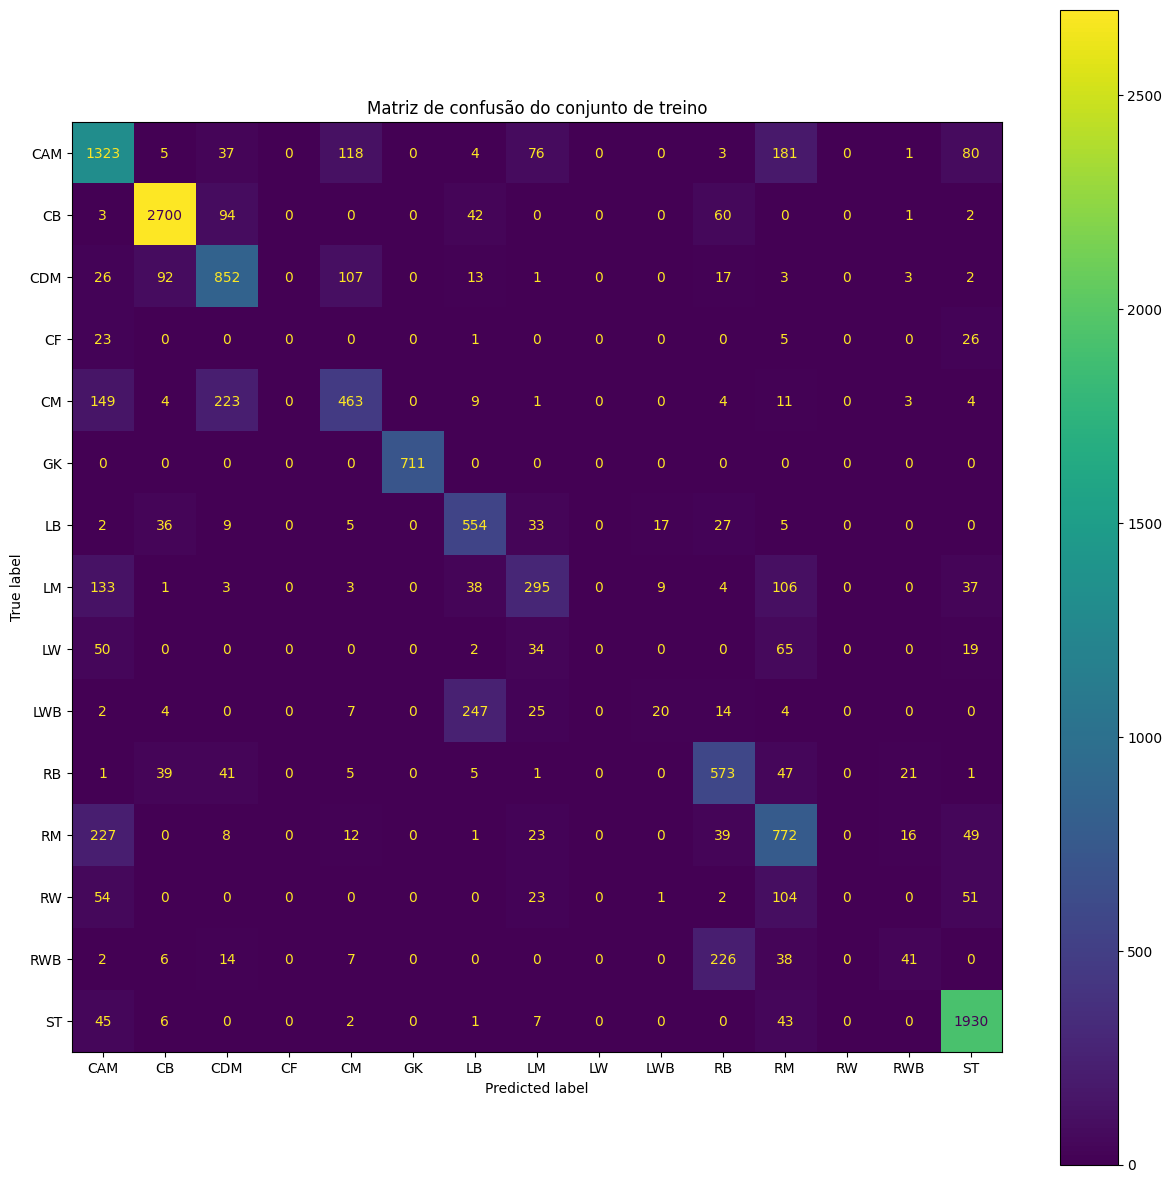

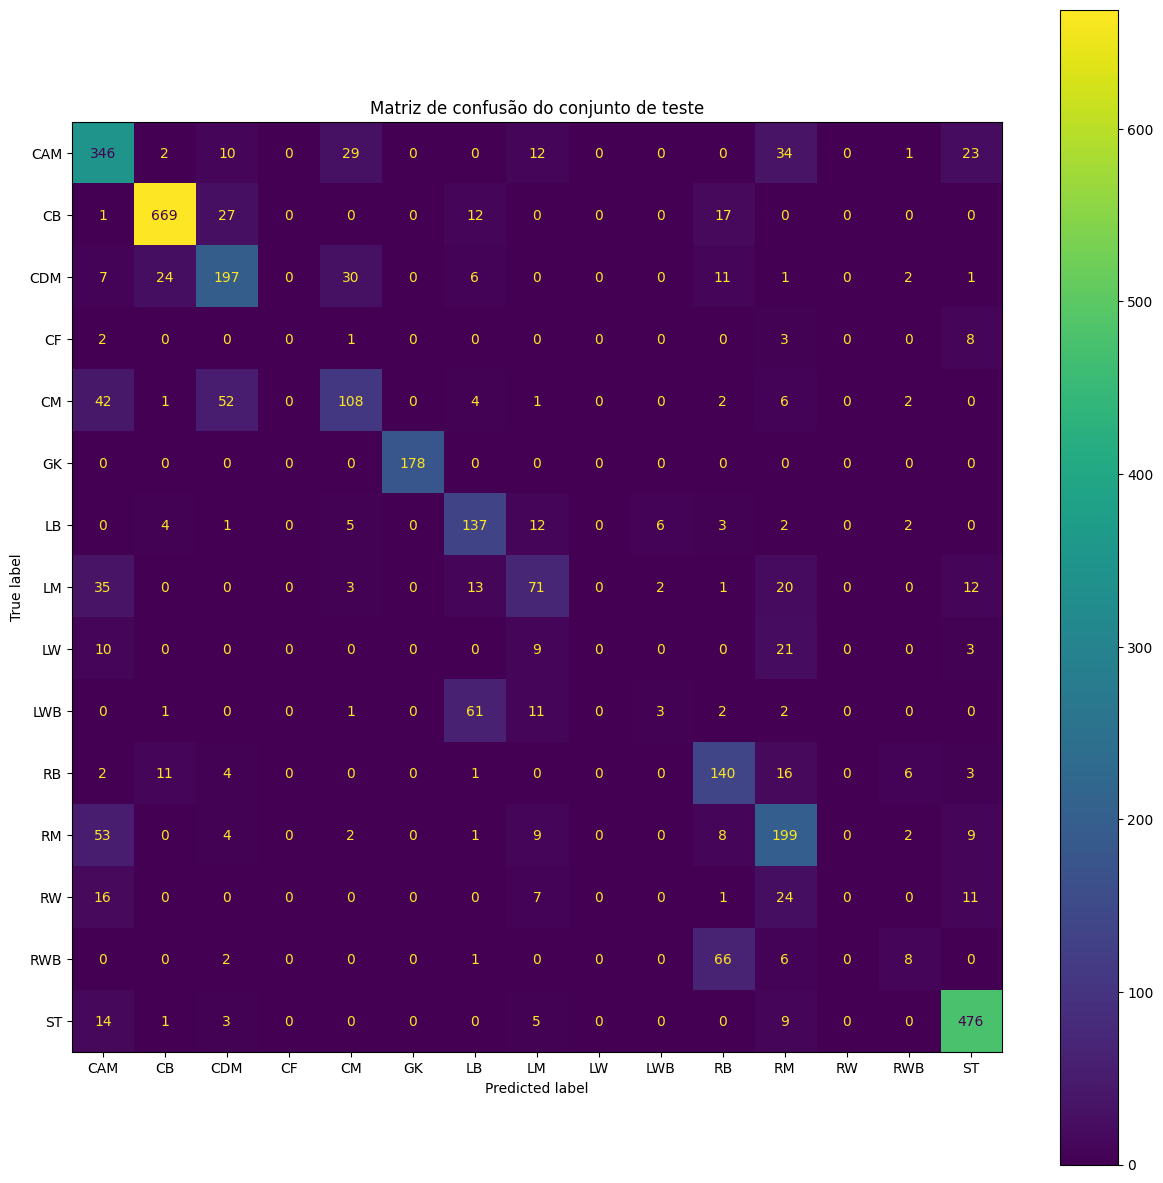

In [28]:
predictions = np.argmax(neuralNetwork.predict(X_train_), axis=-1)
plotConfusionMatrix(predictions, tf.argmax(y_train, axis = 1), list(enc1.categories_[0]), "Matriz de confusão do conjunto de treino")
predictions = np.argmax(neuralNetwork.predict(X_test_), axis=-1)
plotConfusionMatrix(predictions, tf.argmax(y_test, axis = 1), list(enc1.categories_[0]), "Matriz de confusão do conjunto de teste")

### Discussões

As classes desse dataset são bem desequilibradas, enquanto há mais de 3500 zagueiros (CB) há somente 70 segundos atacantes (CF). Isso gera um efeito de "chute", como há poucos CF, o modelo chuta qualquer coisa. Isso é notório em posições como atacante (ST) e zagueiro (CB) que por possuírem muitas instâncias, o modelo acaba chutando várias posições para estas duas. Uma solução para tratar isso é tentar remover alguns zagueiros e outras posições com muito mais jogadores do dataset, tentando manter a proporção original. Isso não será tratado neste notebook, mas serve como ideias futuras para melhorar esse modelo.

# 2° Modelo: Rede Neural + Ensemble

Neste modelo utilizamos uma rede neural inicial para filtrar os jogadores, classificando-os em duas classes: ataque e defesa referente à qual região do campo estes atuam. Em seguida, o jogador era classificado por uma floresta aleatória que classificava somente posições de ataque, caso a rede neural o classificasse como ataque, ou por uma floresta aleatória que só classificava posições de defesa, caso a rede neural o classificasse como defesa.

## Florestas

Com o campo dividido em duas regiões, decidimos por criar uma floresta aleatória especializada em cada uma dessas regiões.

A divisão foi feita do seguinte modo:

Ataque: ST, CF, RF, LF, RW, LW, CAM, RM, LM

Defesa: GK, CB, RB, LB, RWB, LWB, CM, CDM

O código abaixo faz essa separação.

In [29]:
iATK = []
iDEF = []

#percorre o target e o filtra em ataque e defesa
for i, e in enumerate(y_.to_numpy()):
    if e in ["GK", "CB", "RB", "LB", "RWB", "LWB", "CM", "CDM"]:
        iDEF.append(i)
    elif e in ["ST", "CF", "RF", "LF", "RW", "LW", "CAM", "RM", "LM"]:
        iATK.append(i)

#separa o input e output com o filtro criado acima
XATK = X_input[iATK]
yATK = y_.iloc[iATK].squeeze()

XDEF = X_input[iDEF]
yDEF = y_.iloc[iDEF].squeeze()

#transforma o target categórico em númerico
#utilizando LabelEncoder()
enc3 = sklp.LabelEncoder()
enc3.fit(yATK)
yATK = enc3.transform(yATK)
print(f"Posições de ataque: {enc3.classes_}")

enc4 = sklp.LabelEncoder()
enc4.fit(yDEF)
yDEF = enc4.transform(yDEF)
print(f"Posições de defesa: {enc4.classes_}")

#splita o conjunto de treino e teste
XATK_train, XATK_test, yATK_train, yATK_test = train_test_split(XATK, yATK, test_size=0.2, stratify=yATK, random_state=8)
XDEF_train, XDEF_test, yDEF_train, yDEF_test = train_test_split(XDEF, yDEF, test_size=0.2, stratify=yDEF, random_state=8)

#tratamento do X
XATK_train_, XATK_test_, standardScaler1 = standardData(XATK_train, XATK_test)
XDEF_train_, XDEF_test_, standardScaler2 = standardData(XDEF_train, XDEF_test)

Posições de ataque: ['CAM' 'CF' 'LM' 'LW' 'RM' 'RW' 'ST']
Posições de defesa: ['CB' 'CDM' 'CM' 'GK' 'LB' 'LWB' 'RB' 'RWB']


----

Em seguida alguns tamanhos de florestas foram testados, mas as precisões ficaram tão próximas umas das outras que optamos por utilizar uma floresta menor ainda. 

teste com 101 árvores
teste com 201 árvores
teste com 301 árvores
teste com 401 árvores
teste com 501 árvores


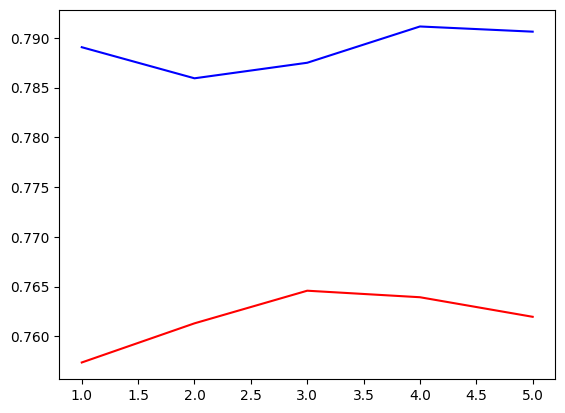

In [30]:
scoresATK = []
scoresDEF = []

size = 5

for i in range(1, size+1):
    print(f"teste com {100 * i + 1} árvores")
    forestATK = RandomForestClassifier(100 * i + 1)
    forestDEF = RandomForestClassifier(100 * i + 1)
    forestATK.fit(XATK_train_, yATK_train)
    forestDEF.fit(XDEF_train_, yDEF_train)
    scoresATK.append(forestATK.score(XATK_test_, yATK_test))
    scoresDEF.append(forestDEF.score(XDEF_test_, yDEF_test))

plt.plot(range(1, size+1), scoresATK, label="ATK", color="red")
plt.plot(range(1, size+1), scoresDEF, label="DEF", color="blue")

In [31]:
print(scoresATK)
print(scoresDEF)

[0.7573770491803279, 0.761311475409836, 0.7645901639344262, 0.7639344262295082, 0.7619672131147541]
[0.7890625, 0.7859375, 0.7875, 0.7911458333333333, 0.790625]


In [32]:
forestATK = RandomForestClassifier(51)
forestDEF = RandomForestClassifier(51)
forestATK.fit(XATK_train_, yATK_train)
forestDEF.fit(XDEF_train_, yDEF_train)
print(forestATK.score(XATK_test_, yATK_test))
print(forestDEF.score(XDEF_test_, yDEF_test))

0.7475409836065574
0.7776041666666667


Abaixo as matrizes de confusão no conjunto de teste dos modelos. A primeira é referente à floresta aleatória focada em posições de a ataque e a segunda na focada em posições de defesa.

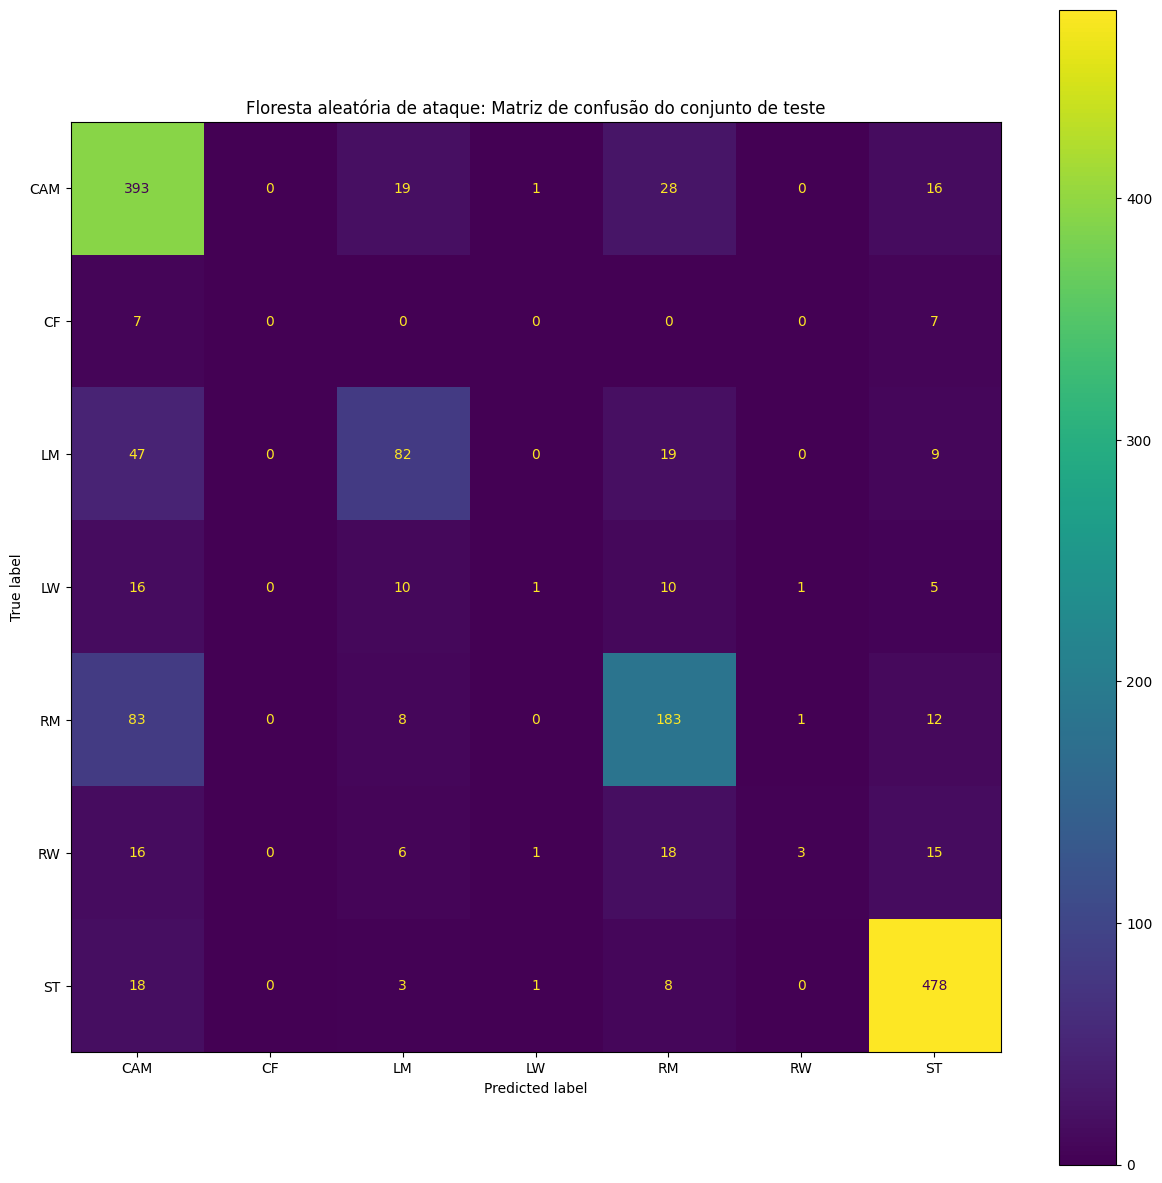

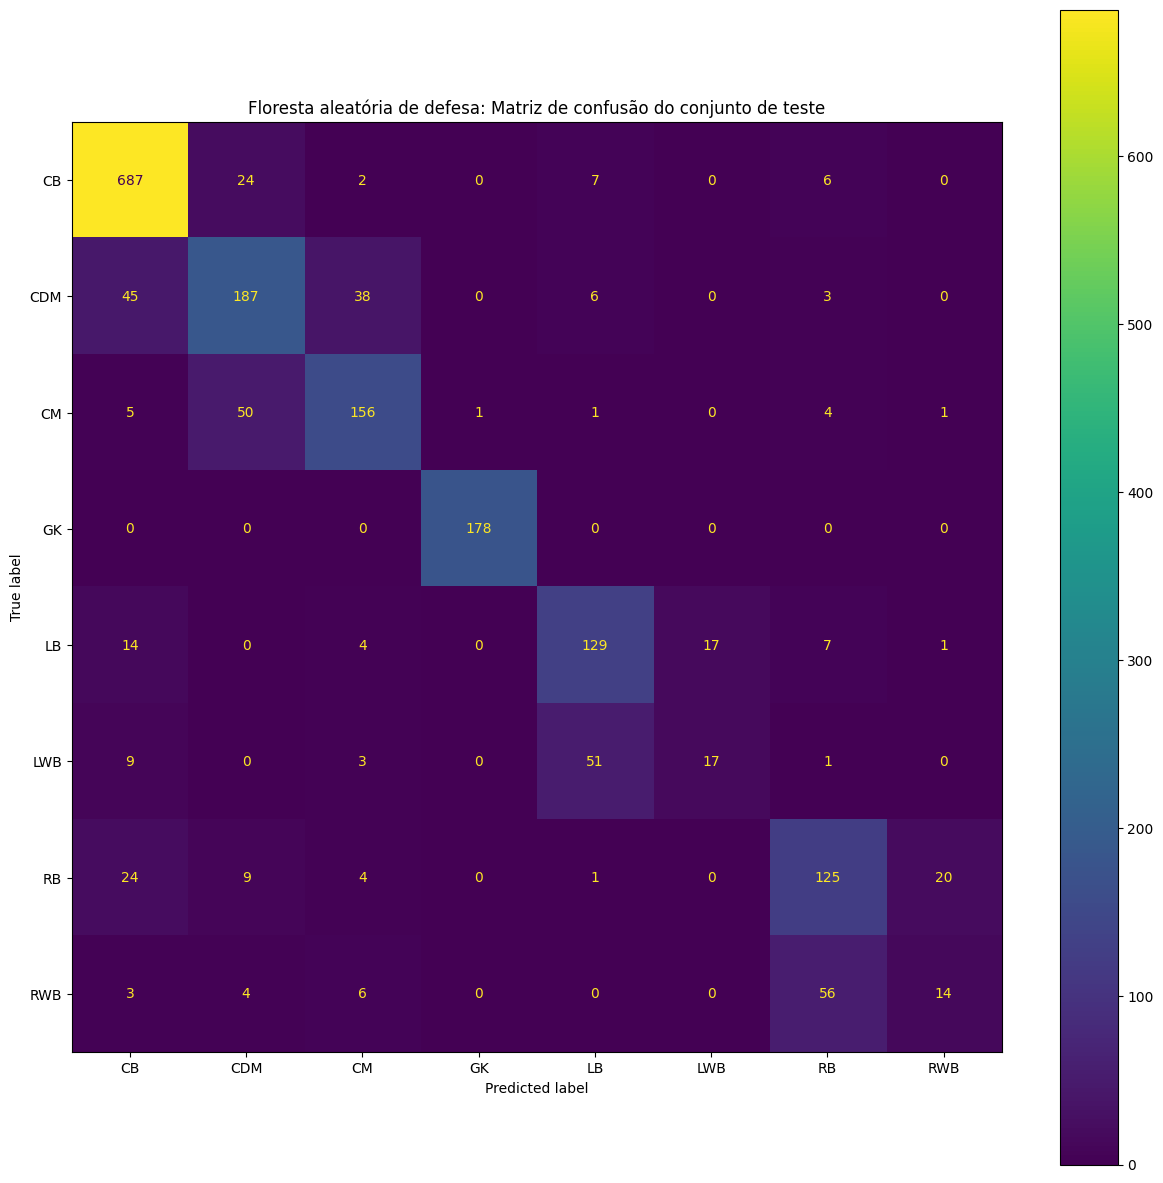

In [33]:
predATK = forestATK.predict(XATK_test_)
predDEF = forestDEF.predict(XDEF_test_)
plotConfusionMatrix(predATK, yATK_test, list(enc3.classes_), "Floresta aleatória de ataque: Matriz de confusão do conjunto de teste")
plotConfusionMatrix(predDEF, yDEF_test, list(enc4.classes_), "Floresta aleatória de defesa: Matriz de confusão do conjunto de teste")

### Breve discussão

Os mesmos erros comentados no modelo de rede neural ocorreram aqui. Posições que somente o lado do campo diferia foram erroneamente classificadas em alguns casos, assim como o modelo errou classes que pouco apareciam no dataset.

## Rede neural

Agora a parte da rede neural. Aqui fizemos uma rede neural MLP comum com um neurônio para cada atributo usado na camada de entrada e somente 2 na camada de saída. O problema agora, diferente do modelo anterior, é classificar somente em qual região do campo um jogador atua. Como se tratava de um problema mais simples, somente um neurônio foi suficiente para uma acurácia acima de 90%. Essencialmente o que está sendo feito aqui é uma mera classificação logística, visto que utilizamos a tangente hiperbólica, que pode ser alcançada através da função sigmoid.

Aqui o output será tratado utilizando LabelEncoder, visto que há somente duas classficações possíveis y se comportará como uma variável binária. Para adequar isso, uso a função de perda SparseCategoricalCrossentropy do tensorflow. Essencialmente é uma entropia cruzada categórica convencional, mas que trabalha com classes enumeradas, como o LabelEncoder ou OrdinalEncoder, por exemplo.

Novamente a tangente hiperbólica foi escolhida devido à sua maior precisão. Após os testes a matriz de confusão de treino e teste, respectivamente, é mostrada, mas não conseguimos obter muita informação dela.

In [34]:
#filtra as posições do target em dois grandes grupos
y_group = np.copy(y_).squeeze()

y_group[iATK] = "ATK"
y_group[iDEF] = "DEF"

encoder = sklp.LabelEncoder()
encoder.fit(y_group)
y_group = encoder.transform(y_group)

In [35]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_input, y_group,
                                        test_size=test_size, stratify=y_group,
                                        random_state=8)
X_train_, X_test_, scaler = standardData(X_train, X_test)

fold 1 começou
fold 2 começou
fold 3 começou
fold 4 começou
fold 5 começou
Config das camadas escondidas (cada elemento é o número de neurônios em cada camada escondida:
 [1]


Logística:
Fold 0 acurácia do treino: 0.7383540630340576         	 acurácia de validação: 0.7466981112957001
Fold 1 acurácia do treino: 0.9106160998344421         	 acurácia de validação: 0.9264150977134704
Fold 2 acurácia do treino: 0.9153511166572571         	 acurácia de validação: 0.9265698730945587
Fold 3 acurácia do treino: 0.9080928921699524         	 acurácia de validação: 0.9330308556556701
Fold 4 acurácia do treino: 0.8737887799739837         	 acurácia de validação: 0.8985117912292481
média das acurácias de treino dos folds = 0.8692405903339386 	     folds val_accuracies mean = 0.8862451457977295


Tanh:
Fold 0 acurácia do treino: 0.9371563494205475         	 acurácia de validação: 0.9432873666286469
Fold 1 acurácia do treino: 0.9418927550315856         	 acurácia de validação: 0.9377358436584473
Fold

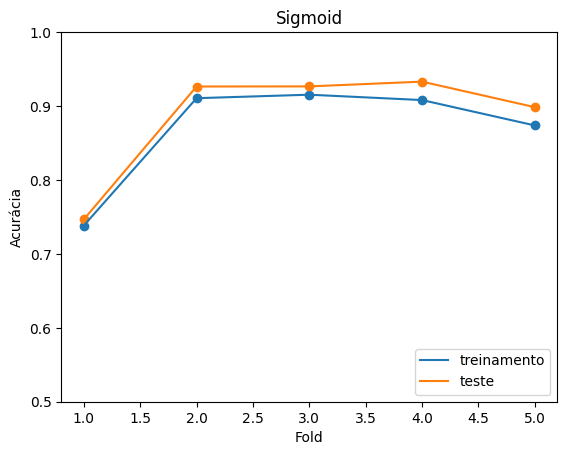

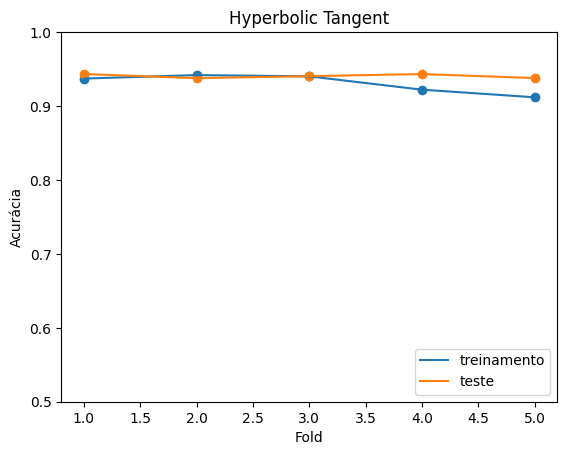

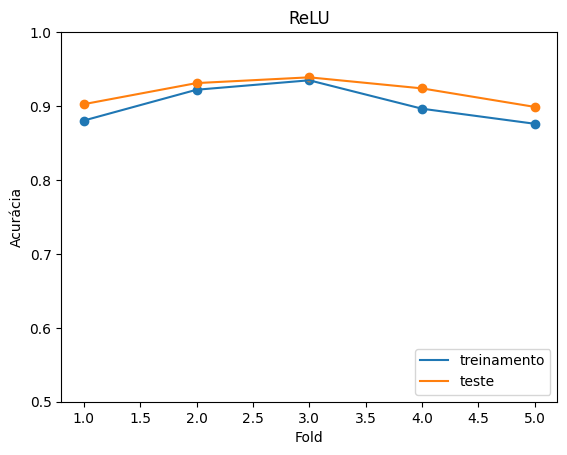

In [36]:
hiddenLayers = [1]
calculate(X_train, y_train, 5, hiddenLayers, X_train.shape[1], 2, 10, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

Epoch 1/10
431/431 [==============================] - 1s 3ms/step - loss: 0.3766 - accuracy: 0.8664 - val_loss: 0.2726 - val_accuracy: 0.9144
Epoch 2/10
431/431 [==============================] - 1s 2ms/step - loss: 0.2210 - accuracy: 0.9313 - val_loss: 0.2074 - val_accuracy: 0.9300
Epoch 3/10
431/431 [==============================] - 1s 2ms/step - loss: 0.1787 - accuracy: 0.9392 - val_loss: 0.1809 - val_accuracy: 0.9382
Epoch 4/10
431/431 [==============================] - 1s 2ms/step - loss: 0.1595 - accuracy: 0.9441 - val_loss: 0.1680 - val_accuracy: 0.9411
Epoch 5/10
431/431 [==============================] - 1s 2ms/step - loss: 0.1492 - accuracy: 0.9457 - val_loss: 0.1605 - val_accuracy: 0.9411
Epoch 6/10
431/431 [==============================] - 1s 3ms/step - loss: 0.1437 - accuracy: 0.9461 - val_loss: 0.1563 - val_accuracy: 0.9396
Epoch 7/10
431/431 [==============================] - 1s 2ms/step - loss: 0.1407 - accuracy: 0.9457 - val_loss: 0.1547 - val_accuracy: 0.9399
Epoch 

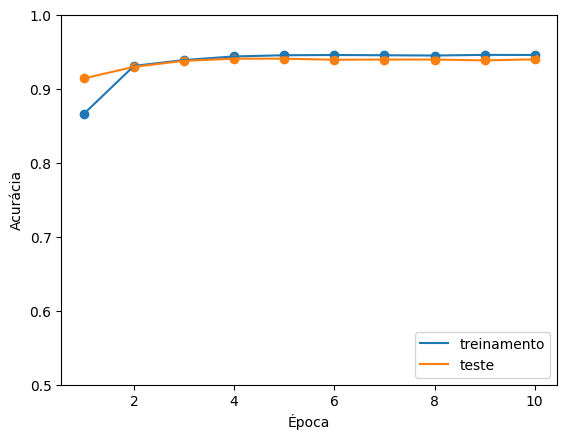

In [37]:
hiddenLayers = [1]
neuralNetwork, history, testLoss, testAccuracy = testModel(X_train_, y_train, X_test_, y_test, verbose=1, ls=hiddenLayers, input=X_input.shape[1],
          output=2, activation="tanh", optimizer="sgd",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'], epochs=10)

plotHistory(history)

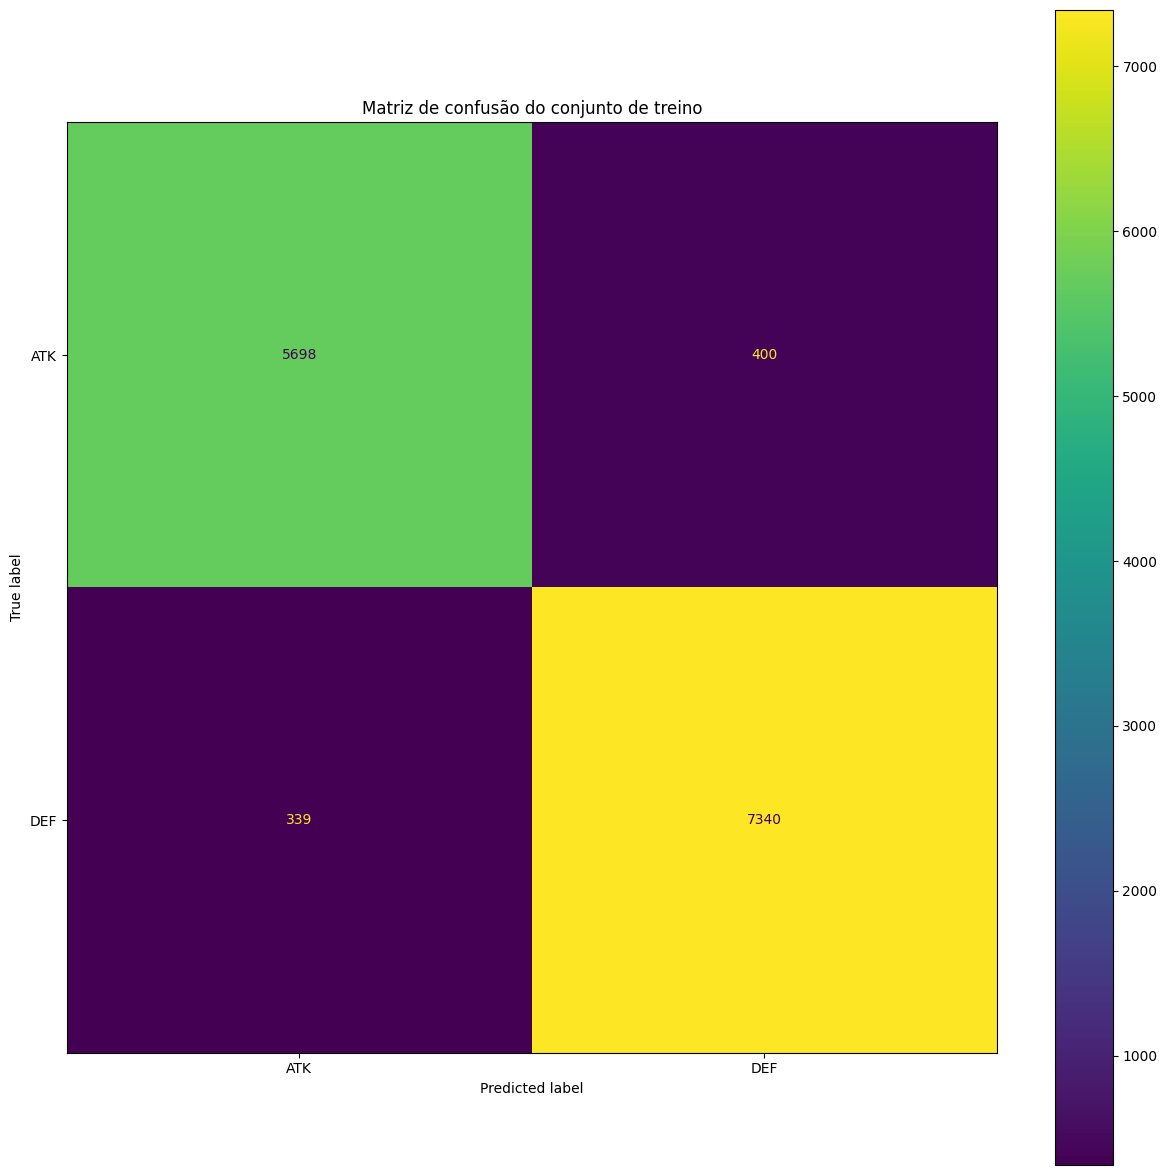

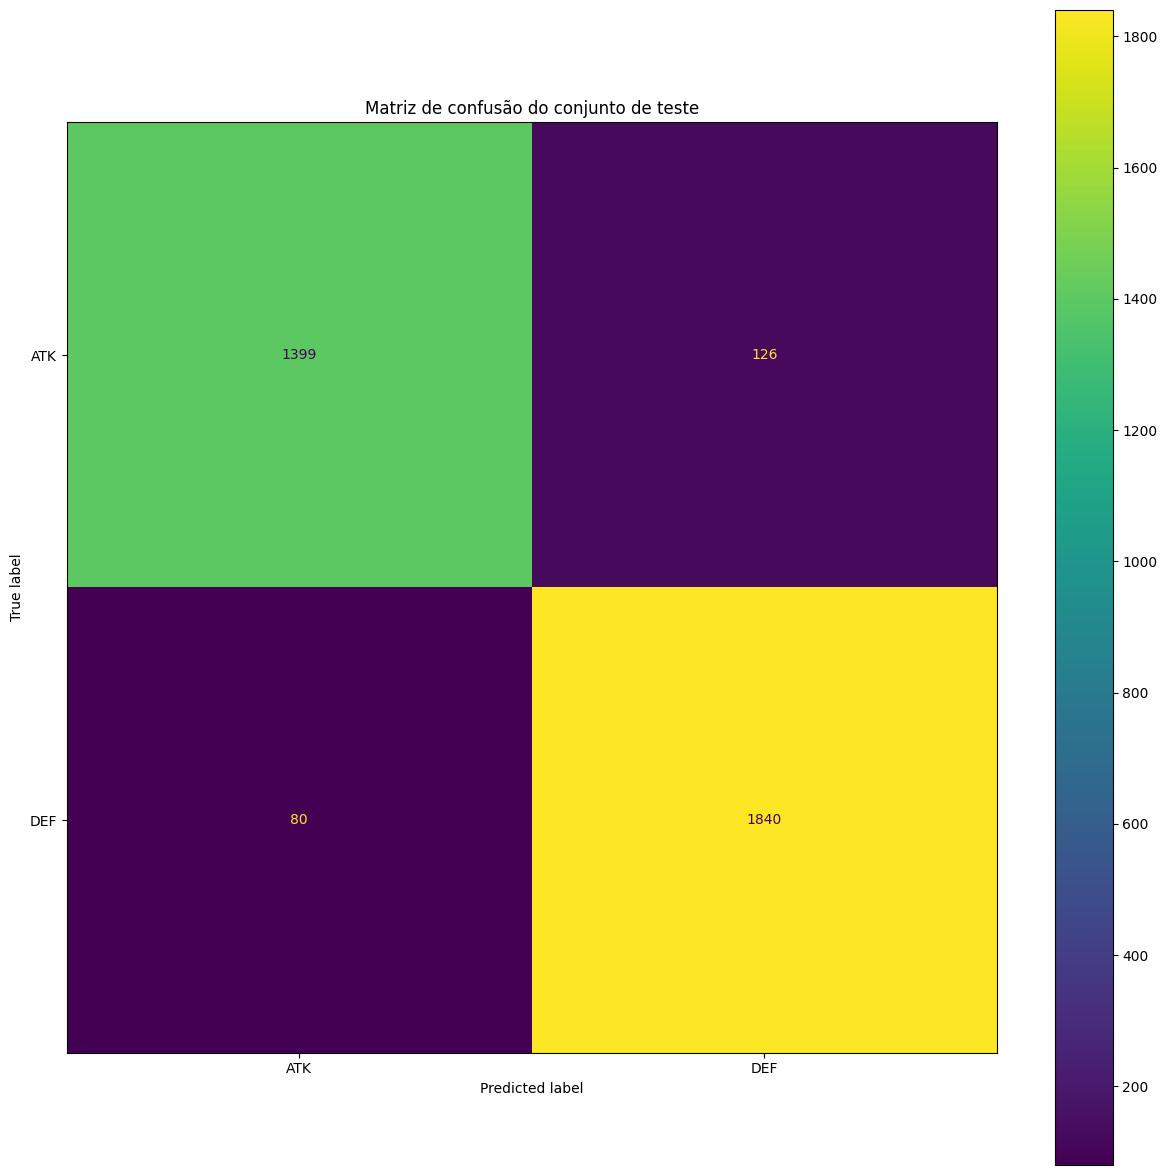

In [38]:
predictions_train = np.argmax(neuralNetwork.predict(X_train_), axis=-1)
predictions_test = np.argmax(neuralNetwork.predict(X_test_), axis=-1)

plotConfusionMatrix(predictions_train, y_train, list(encoder.classes_), "Matriz de confusão do conjunto de treino")
plotConfusionMatrix(predictions_test, y_test, list(encoder.classes_), "Matriz de confusão do conjunto de teste")

### Avaliação do método

O processo de predição do método consiste em duas partes:

1. A instância passa pela rede neural para ser classificada em ataque ou defesa.
2. Se a classe determinada for ataque, a instância passa para a floresta aleatória especializada em posições de ataque. Caso contrário, é passada para a floresta aleatória de defesa.

In [39]:
def predictEnsemble(nn, forestATK, forestDEF, X):
    '''
    Função de predição para o ensemble. Primeiro a rede neural classifica a
    instância em duas regiões do campo e em seguida, baseado nesse resultado,
    é classficiada por uma das duas florestas aleatórias.
    Entrada:
        rede neural;
        florestas aleatórias de ataque e defesa;
        conjunto a ser classificado.
    Saída:
        predições.
    '''
    pred = np.argmax(nn.predict(X), axis=-1)
    predictions = np.zeros((X.shape[0],))
    zeroIndex = []
    oneIndex = []

    for i, p in enumerate(pred):
        if p == 0:
            zeroIndex.append(i)
        elif p == 1:
            oneIndex.append(i)
    predictions[zeroIndex] = forestATK.predict(X[zeroIndex, :])
    predictions[oneIndex] = forestDEF.predict(X[oneIndex, :]) + 7
    return predictions

In [40]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_input, y_group,
                                        test_size=test_size, stratify=y_group,
                                        random_state=8)
X_train_, X_test_, standardScaler4 = standardData(X_train, X_test)

predictions = predictEnsemble(neuralNetwork, forestATK, forestDEF, standardScaler4.transform(X_input))

In [41]:
#tratamento dos labels para a matriz de confusão
labels = list(enc3.classes_) + list(enc4.classes_)
posDict = {}
ynew = []
for i, l in enumerate(labels):
    posDict[l] = i

for pos in y_["Best Position"].iloc[:]:
    ynew.append(posDict[pos])

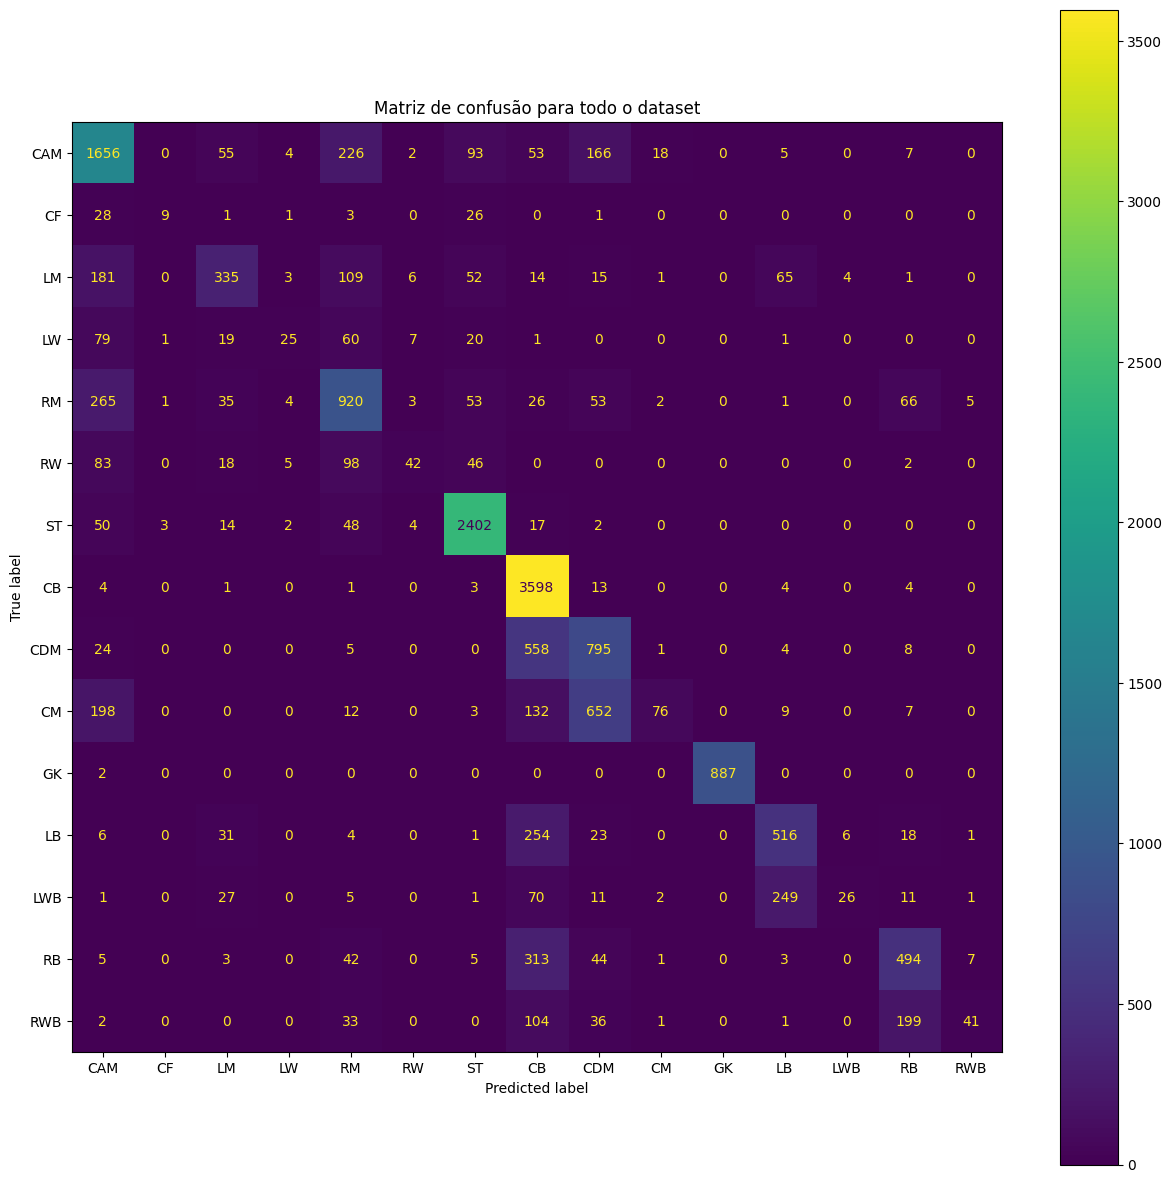

In [42]:
plotConfusionMatrix(predictions, ynew, labels, "Matriz de confusão para todo o dataset")

In [43]:
count = 0
for i, player in enumerate(ynew):
    if player == predictions[i]:
        count+=1

count / len(ynew)

0.6864475670653815

Os resultados no geral foram bem ruins, com uma precisão de somente ~69%. Acreditamos que um problema principal seja a precisão da árvore de ataque e o desbalanceio da posição ST para as outras. Note que no quadrado do canto superior esquerdo é justamente o caso onde a rede neural corretamente determinava o jogador com uma posição da região de ataque e a floresta de ataque o classificava, Há inúmeros erros e muitos chutes para a posição ST.

A árvore de defesa não sai muito deste caso de chutes, visto que CB é desbalanceado também e a floresta fez inúmeros chutes nessa posição.

Uma possível solução seria retirar jogadores que fossem ST e CB dos dados para treino e teste a fim de amenizar essa discrepância entre as diferentes possíveis. De fato, tal alteração poderia beneficiar até mesmo o primeiro modelo, que consistia somente de uma rede neural MLP única.

# Simplificação de posições "redundantes"

Como um bônus, pensamos em juntar algumas posições que pudessem soar ambíguas, como lateral esquerdo (LB) e lateral direito (RB) a fim de verificar se o modelo se sairia melhor. Os resultados foram positivos!

Esses testes foram feitos no 1° modelo, que era um rede neural MLP convencional.

In [44]:
ynew = np.copy(y_)

for i, player in enumerate(ynew[:, 0]):
    if player == "LW" or player == "RW" or player == "LM" or player == "RM":
        ynew[i, 0] = "SM_W"
    elif player == "LB" or player == "RB" or player == "RWB" or player == "LWB":
        ynew[i, 0] = "SB"

In [45]:
#tratamento do y
enc5 = sklp.OneHotEncoder(sparse_output=False)
enc5.fit(ynew)
ynew = enc5.transform(ynew)

In [46]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_input, ynew,
                                        test_size=test_size, stratify=ynew,
                                        random_state=8)
X_train_, X_test_, _ = standardData(X_train, X_test)

Epoch 1/30
431/431 [==============================] - 2s 3ms/step - loss: 1.2164 - accuracy: 0.5903 - val_loss: 0.8046 - val_accuracy: 0.7216
Epoch 2/30
431/431 [==============================] - 1s 3ms/step - loss: 0.6829 - accuracy: 0.7568 - val_loss: 0.6125 - val_accuracy: 0.7794
Epoch 3/30
431/431 [==============================] - 1s 3ms/step - loss: 0.5681 - accuracy: 0.7938 - val_loss: 0.5420 - val_accuracy: 0.8052
Epoch 4/30
431/431 [==============================] - 1s 3ms/step - loss: 0.5227 - accuracy: 0.8047 - val_loss: 0.5133 - val_accuracy: 0.8084
Epoch 5/30
431/431 [==============================] - 1s 3ms/step - loss: 0.5017 - accuracy: 0.8092 - val_loss: 0.4984 - val_accuracy: 0.8110
Epoch 6/30
431/431 [==============================] - 1s 3ms/step - loss: 0.4906 - accuracy: 0.8135 - val_loss: 0.4907 - val_accuracy: 0.8131
Epoch 7/30
431/431 [==============================] - 1s 3ms/step - loss: 0.4834 - accuracy: 0.8153 - val_loss: 0.4842 - val_accuracy: 0.8128
Epoch 

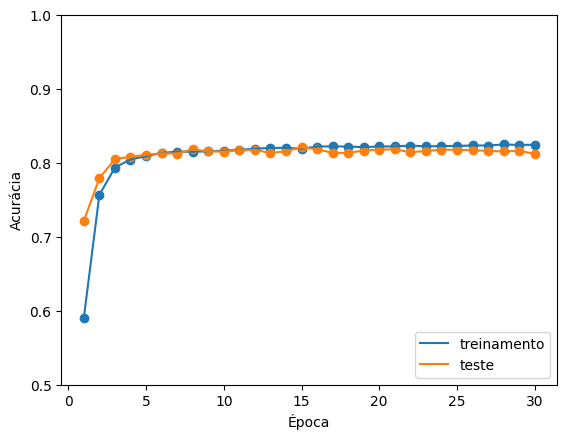

In [47]:
hiddenLayers = [32, 64, 32]
neuralNetwork, history, testLoss, testAccuracy = testModel(X_train_, y_train, X_test_, y_test, verbose=1, ls=hiddenLayers, input=X_input.shape[1],
          output=9, activation="tanh", optimizer="sgd",
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'], epochs=30)

plotHistory(history)

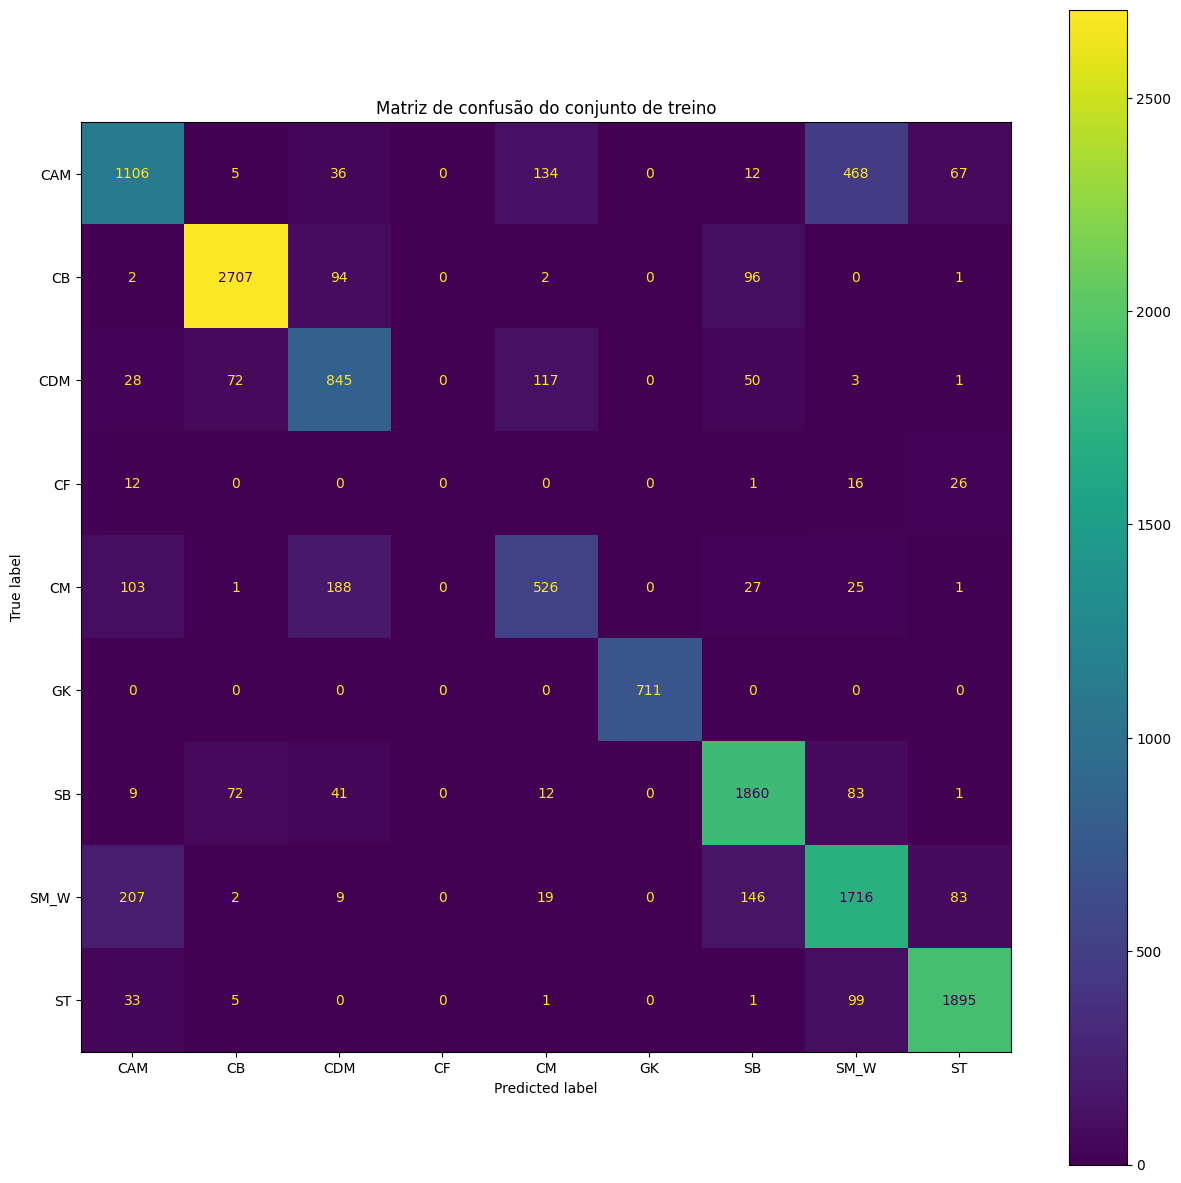

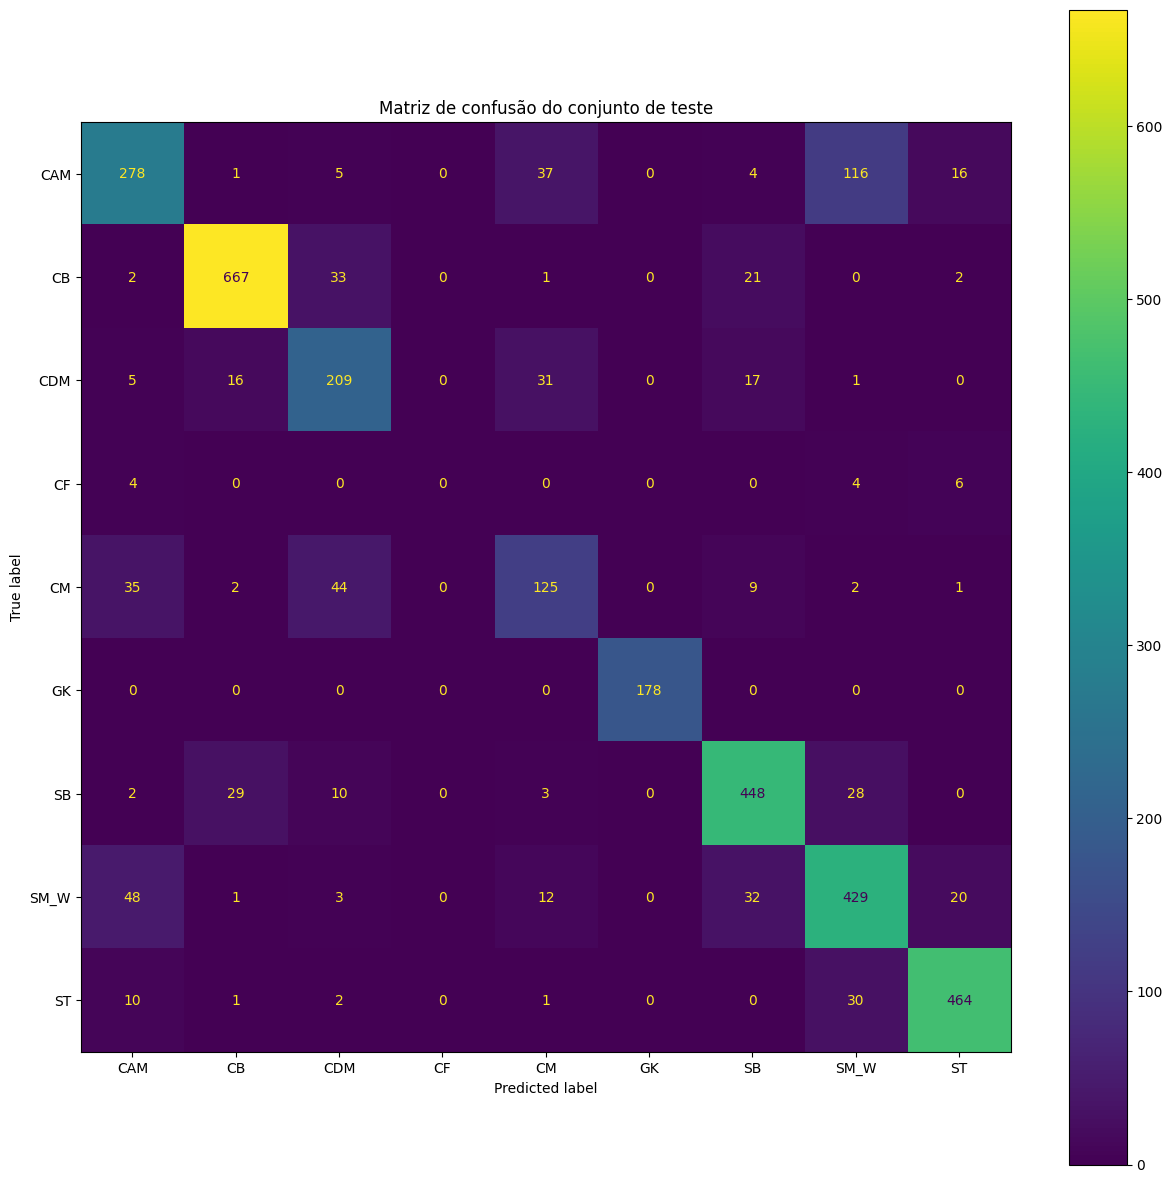

In [48]:
predictions = np.argmax(neuralNetwork.predict(X_train_), axis=-1)
plotConfusionMatrix(predictions, tf.argmax(y_train, axis = 1), list(enc5.categories_[0]), "Matriz de confusão do conjunto de treino")
predictions = np.argmax(neuralNetwork.predict(X_test_), axis=-1)
plotConfusionMatrix(predictions, tf.argmax(y_test, axis = 1), list(enc5.categories_[0]), "Matriz de confusão do conjunto de teste")